<a href="https://colab.research.google.com/github/Avniiii2606/Career-Counselling-ChatBot/blob/main/KAN_Effort_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Multi-Dataset KAN Regression for Software Effort Estimation
TESTING ALBRECHT DATASET FEATURE ENGINEERING
Testing Albrecht feature engineering...
Original sample data shape: (100, 9)
Original columns: ['Inputs', 'Outputs', 'Inquiries', 'Files', 'Interfaces', 'Effort', 'Duration', 'Language', 'Year']
ERROR during processing: name 'engineer_features_albrecht' is not defined
First, let's analyze your NASA93 dataset structure...
=== NASA93 Dataset Analysis ===


Traceback (most recent call last):
  File "/tmp/ipython-input-699789025.py", line 402, in test_albrecht_feature_engineering
    processed_albrecht = engineer_features_albrecht(sample_albrecht.copy())
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'engineer_features_albrecht' is not defined. Did you mean: 'engineer_features_maxwell'?


Shape: (92, 17)
Columns: ['1.15', '0.94', '1.15.1', '1', '1.1', '0.87', '0.87.1', '1.2', '1.3', '1.4', '1.5', '0.95', '0.91', '1.6', '1.08', '25.9', '117.6']

First 3 rows:
   1.15  0.94  1.15.1    1  1.1  0.87  0.87.1  1.2  1.3  1.4  1.5  0.95  0.91  \
0  1.15  0.94    1.15  1.0  1.0  0.87    0.87  1.0  1.0  1.0  1.0  0.95  0.91   
1  1.15  0.94    1.15  1.0  1.0  0.87    0.87  1.0  1.0  1.0  1.0  0.95  0.91   
2  1.15  0.94    1.15  1.0  1.0  0.87    0.87  1.0  1.0  1.0  1.0  0.95  0.91   

   1.6  1.08  25.9  117.6  
0  1.0  1.08  24.6  117.6  
1  1.0  1.08   7.7   31.2  
2  1.0  1.08   8.2   36.0  

Data types:
1.15      float64
0.94      float64
1.15.1    float64
1         float64
1.1       float64
0.87      float64
0.87.1    float64
1.2       float64
1.3       float64
1.4       float64
1.5       float64
0.95      float64
0.91      float64
1.6       float64
1.08      float64
25.9      float64
117.6     float64
dtype: object

Numeric columns: ['1.15', '0.94', '1.15.1', '1', '1.1', 

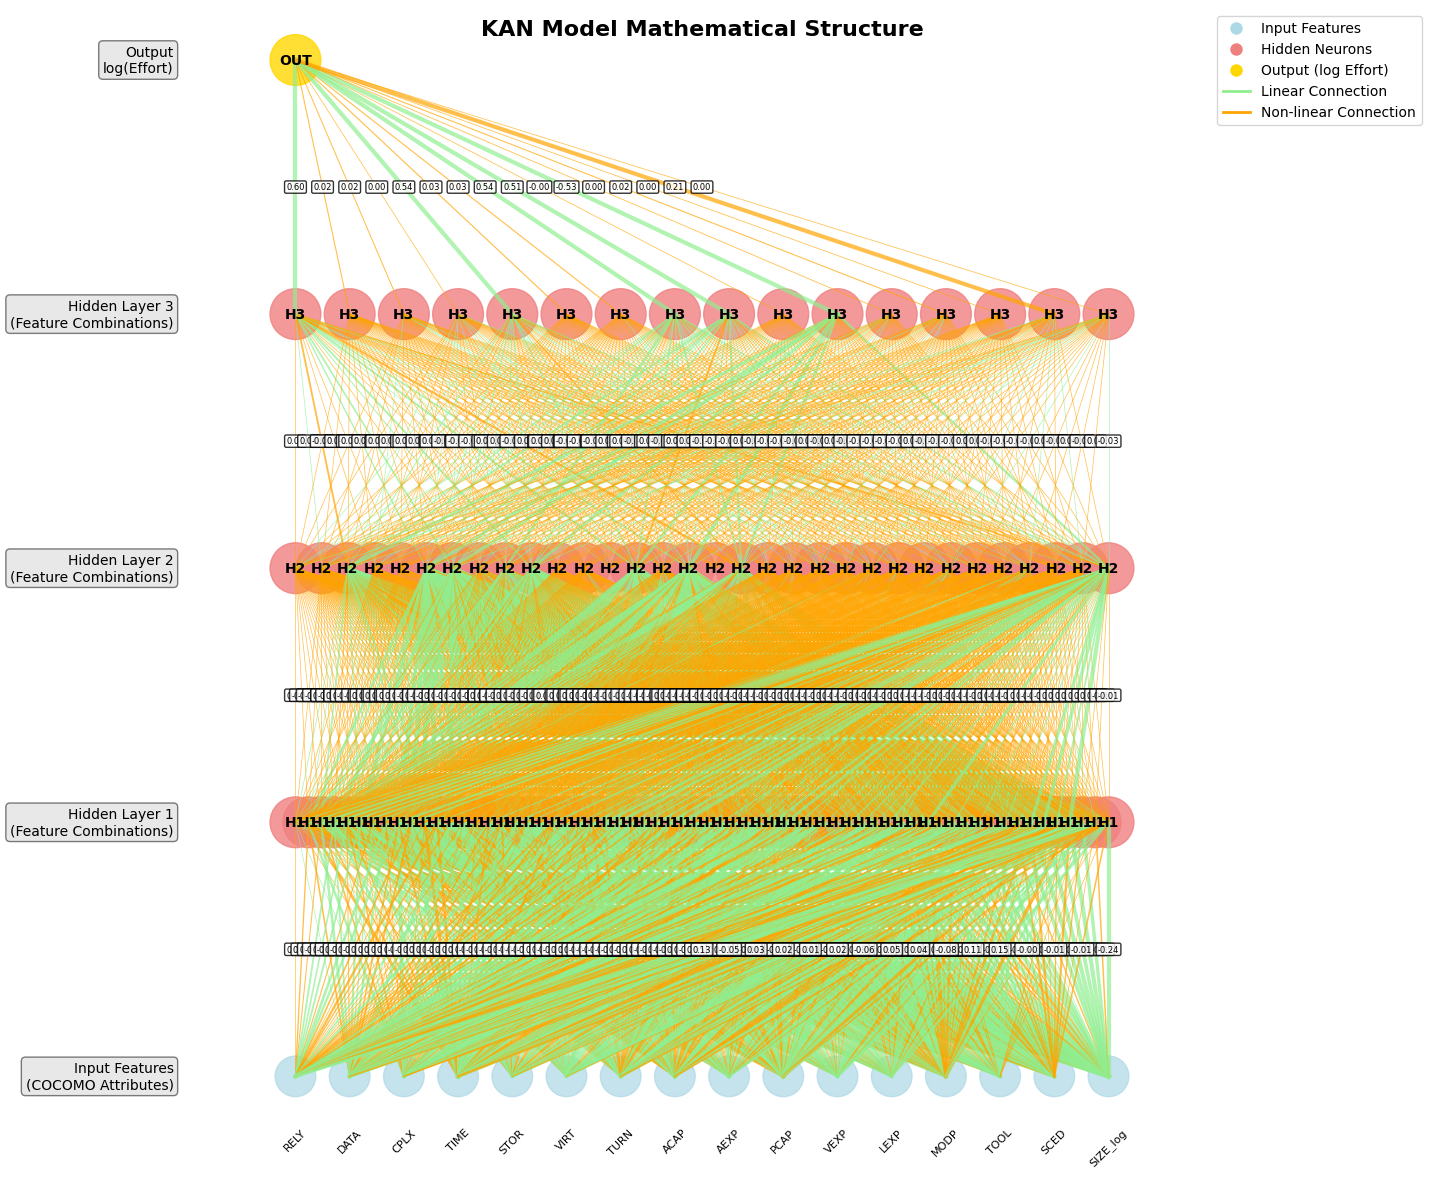


Mathematical Tree Interpretation:
----------------------------------------
• Blue circles: Input COCOMO features
• Coral circles: Hidden layer neurons (feature combinations)
• Gold circle: Final output (log of effort)
• Green lines: Linear transformations
• Orange lines: Non-linear (B-spline) transformations
• Line thickness: Strength of connection

The tree shows how COCOMO features flow through the KAN network
to produce the final effort estimate through learned mathematical
transformations that capture both linear and non-linear relationships.

Step 4: Comparing with Traditional COCOMO Equations...
COMPARISON: KAN MODEL vs TRADITIONAL COCOMO
1. TRADITIONAL COCOMO EQUATIONS:
-----------------------------------
COCOMO 81 Basic:
  Effort = a × (KLOC)^b
  where a ∈ [2.4, 3.6], b ∈ [1.05, 1.20]

COCOMO 81 Intermediate:
  Effort = a × (KLOC)^b × ∏(EM_i)
  where EM_i are 15 effort multipliers:
    EM_ 1: RELY
    EM_ 2: DATA
    EM_ 3: CPLX
    EM_ 4: TIME
    EM_ 5: STOR
    EM_ 6: VIRT


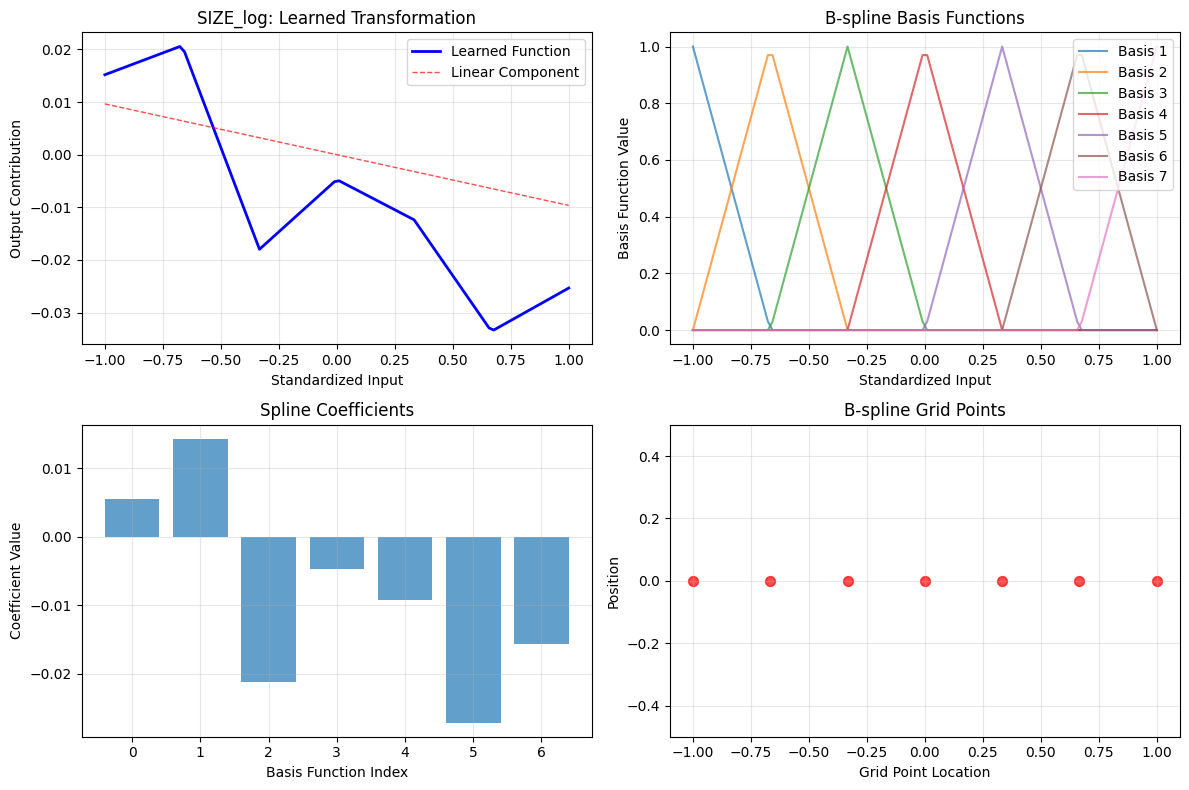


Numerical Summary for SIZE_log:
  Base linear weight: -0.009638
  Spline coefficient range: [-0.027135, 0.014285]
  Grid points: [-1.0000000e+00 -6.6666663e-01 -3.3333331e-01 -2.9802322e-08
  3.3333331e-01  6.6666663e-01  1.0000000e+00]
  Non-linearity strength: 0.013578

Visualizing splines for PCAP (Rank 2, Importance: 0.0889)
Visualizing B-spline for PCAP (Feature 10)


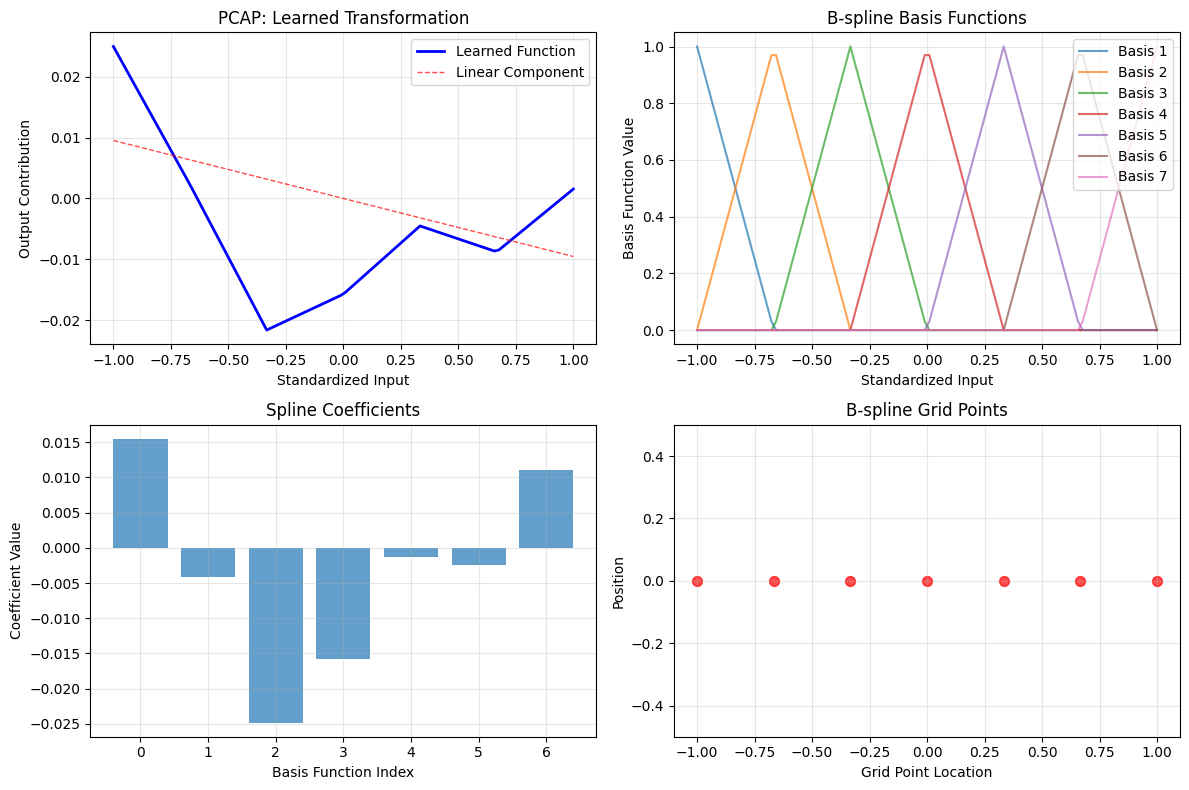


Numerical Summary for PCAP:
  Base linear weight: -0.009533
  Spline coefficient range: [-0.024809, 0.015455]
  Grid points: [-1.0000000e+00 -6.6666663e-01 -3.3333331e-01 -2.9802322e-08
  3.3333331e-01  6.6666663e-01  1.0000000e+00]
  Non-linearity strength: 0.012988

Visualizing splines for TIME (Rank 3, Importance: 0.0839)
Visualizing B-spline for TIME (Feature 4)


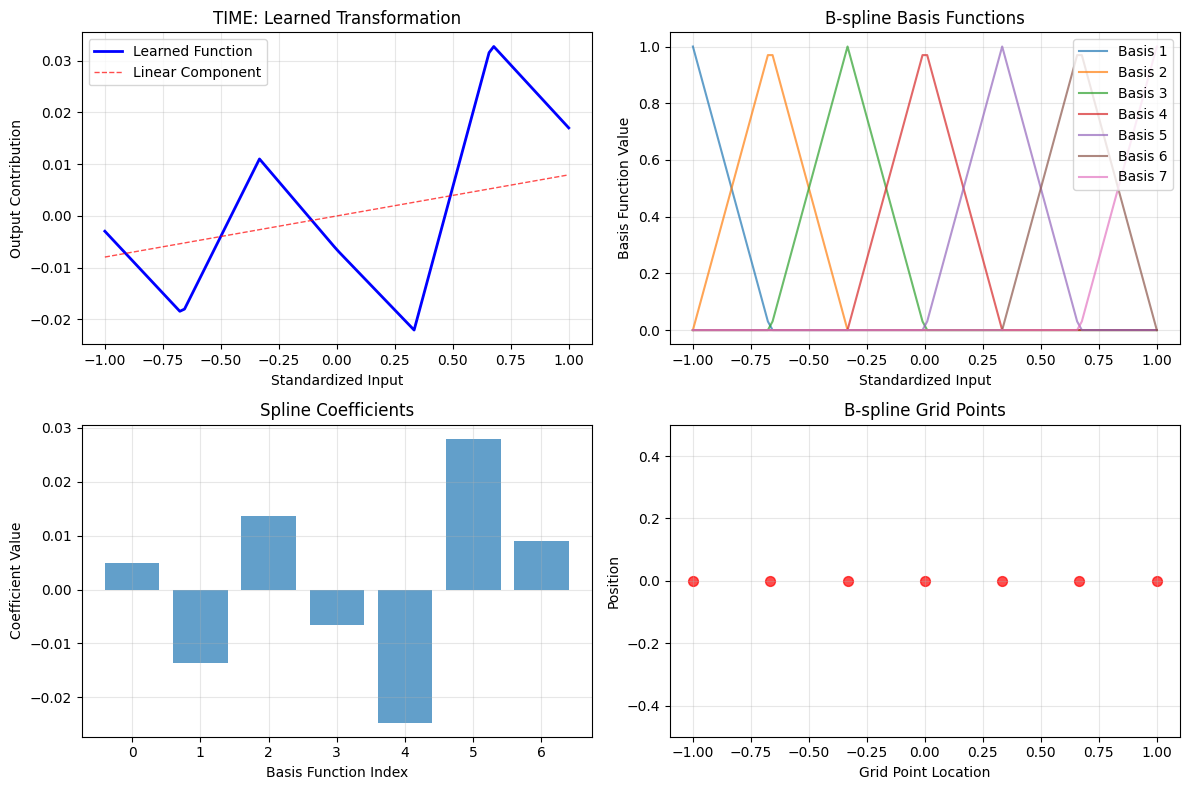


Numerical Summary for TIME:
  Base linear weight: 0.007942
  Spline coefficient range: [-0.024692, 0.027935]
  Grid points: [-1.0000000e+00 -6.6666663e-01 -3.3333331e-01 -2.9802322e-08
  3.3333331e-01  6.6666663e-01  1.0000000e+00]
  Non-linearity strength: 0.016452

COMPREHENSIVE MODEL SUMMARY REPORT
DATASET SUMMARY:
  Total datasets used: 4
  Dataset types: cocomo81, china, maxwell, nasa93
  Combined samples: 316
  Feature dimensions: 16

MODEL CONFIGURATION:
  Architecture: [16] → 64 → 32 → 16 → 1
  Grid size: 7
  Dropout rate: 0.15
  Total parameters: 28,828

PERFORMANCE SUMMARY:
  MSE_log: 0.7524
  MAE_log: 0.6634
  R2_log: 0.8480
  MSE_original: 19196300.0000
  MAE_original: 2016.5912
  R2_original: 0.6682
  MMRE: 54.9604

TOP CONTRIBUTING FEATURES:
  1. SIZE_log  : 0.1502
  2. PCAP      : 0.0889
  3. TIME      : 0.0839
  4. ACAP      : 0.0740
  5. DATA      : 0.0717

MODEL EQUATION SUMMARY:
  Form: Effort = exp(KAN(COCOMO_features))
  Input: 15 COCOMO effort multipliers + SIZE_

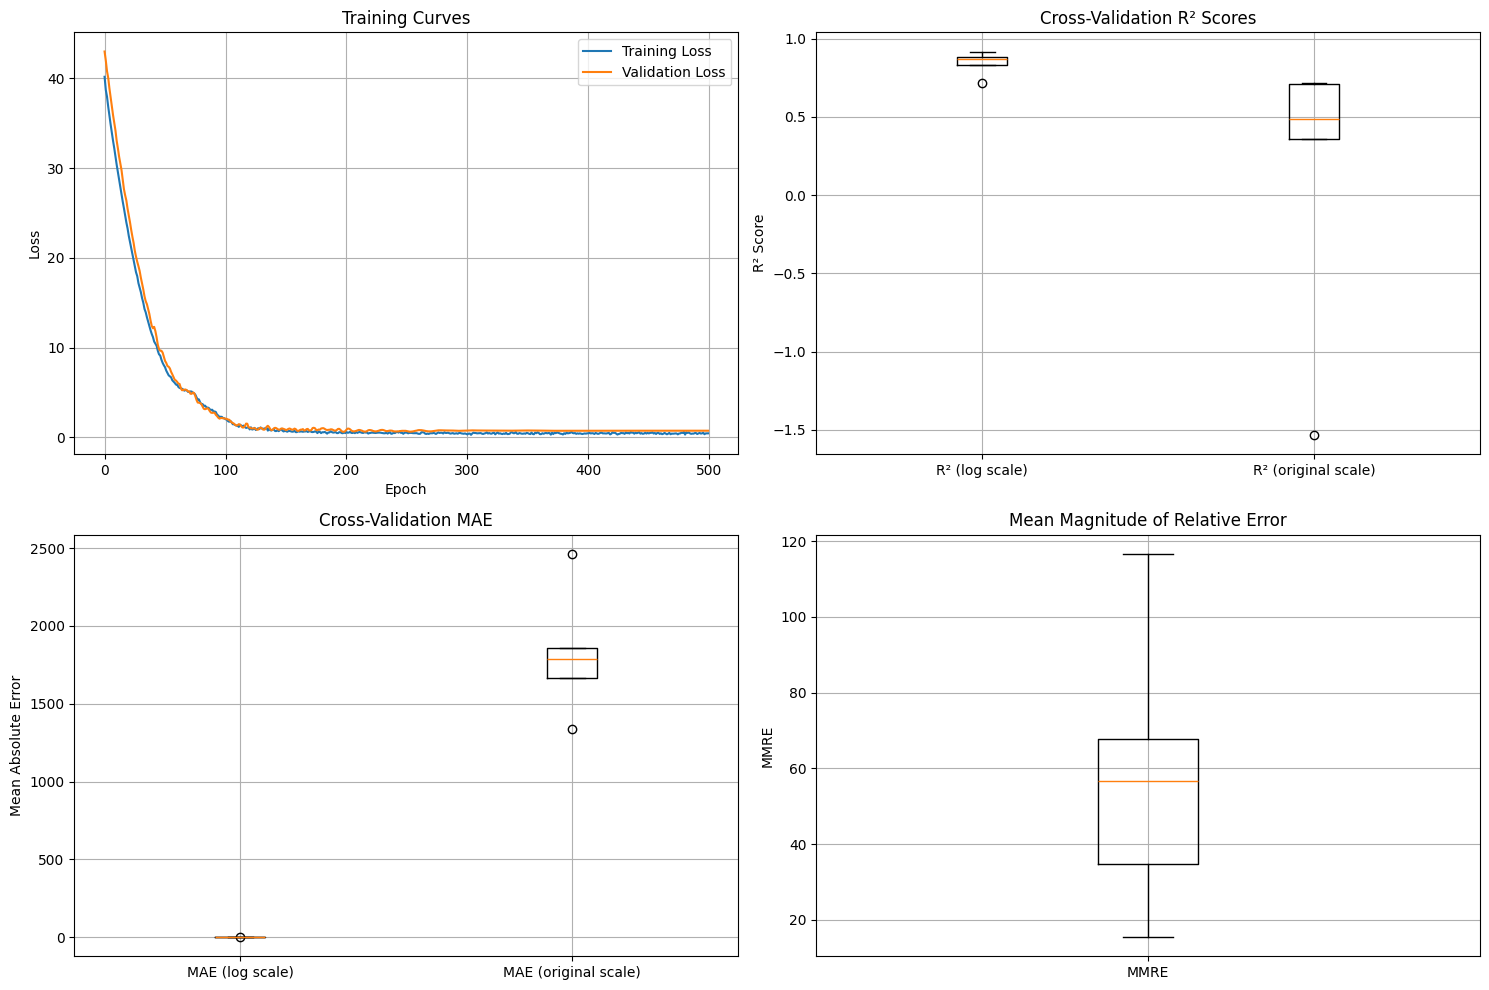


TRAINING AND ANALYSIS COMPLETED SUCCESSFULLY!
The KAN model has been trained and analyzed on 4 dataset(s).
Architecture, equations, and feature interactions have been displayed above.
Model is ready for effort estimation with preserved COCOMO feature hierarchy.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
from tabulate import tabulate

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class KANLayer(nn.Module):
    """
    Kolmogorov-Arnold Network Layer implementation with improved stability
    """
    def __init__(self, input_dim: int, output_dim: int, grid_size: int = 5, spline_order: int = 3):
        super(KANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.grid_size = grid_size
        self.spline_order = spline_order

        # Initialize grid points
        self.grid = nn.Parameter(torch.linspace(-1, 1, grid_size), requires_grad=False)

        # Smaller initialization for spline coefficients
        self.spline_coeffs = nn.Parameter(
            torch.randn(input_dim, output_dim, grid_size) * 0.01
        )

        # Smaller initialization for base weights
        self.base_weight = nn.Parameter(torch.randn(input_dim, output_dim) * 0.01)

    def b_splines(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute B-spline basis functions with better numerical stability
        """
        # Clamp x to grid range and handle edge cases
        x = torch.clamp(x, -1.0, 1.0)

        # Simple linear basis functions for better stability
        grid_size = len(self.grid)
        basis = torch.zeros(x.shape[0], grid_size, device=x.device, dtype=x.dtype)

        # Create simple hat functions (linear interpolation)
        for i in range(grid_size):
            if i == 0:
                # Left boundary
                mask = x <= self.grid[1]
                basis[:, i] = torch.where(mask, 1.0 - torch.abs(x - self.grid[i]) / (self.grid[1] - self.grid[0] + 1e-8), 0.0)
            elif i == grid_size - 1:
                # Right boundary
                mask = x >= self.grid[i-1]
                basis[:, i] = torch.where(mask, 1.0 - torch.abs(x - self.grid[i]) / (self.grid[i] - self.grid[i-1] + 1e-8), 0.0)
            else:
                # Interior points
                left_dist = torch.abs(x - self.grid[i]) / (self.grid[i] - self.grid[i-1] + 1e-8)
                right_dist = torch.abs(x - self.grid[i]) / (self.grid[i+1] - self.grid[i] + 1e-8)
                basis[:, i] = torch.maximum(torch.zeros_like(x), 1.0 - torch.minimum(left_dist, right_dist))

        # Normalize to ensure numerical stability
        basis_sum = basis.sum(dim=1, keepdim=True) + 1e-8
        basis = basis / basis_sum

        return basis

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        output = torch.zeros(batch_size, self.output_dim, device=x.device, dtype=x.dtype)

        # Base linear transformation
        base_output = torch.matmul(x, self.base_weight)

        # Spline transformation for each input dimension
        for i in range(self.input_dim):
            # Get B-spline basis for input dimension i
            basis = self.b_splines(x[:, i:i+1].squeeze(-1))

            # Apply spline coefficients with proper dimensions
            for j in range(self.output_dim):
                if basis.shape[1] <= self.spline_coeffs.shape[2]:
                    coeffs = self.spline_coeffs[i, j, :basis.shape[1]]
                    spline_output = torch.matmul(basis, coeffs)
                    output[:, j] += spline_output

        # Combine base and spline outputs with clipping for stability
        result = base_output + output
        return torch.clamp(result, -10.0, 10.0)  # Prevent extreme values

class KANRegressor(nn.Module):
    """
    KAN model for regression
    """
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int = 1,
                 grid_size: int = 5, dropout_rate: float = 0.1):
        super(KANRegressor, self).__init__()

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input layer
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(KANLayer(current_dim, hidden_dim, grid_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim

        # Output layer
        self.layers.append(KANLayer(current_dim, output_dim, grid_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, (layer, dropout) in enumerate(zip(self.layers[:-1], self.dropouts)):
            x = layer(x)
            x = torch.relu(x)  # Activation between layers
            x = dropout(x)

        # Final layer without activation
        x = self.layers[-1](x)
        return x


def create_capability_proxies_china(data):
    """
    Create ACAP and PCAP proxies from China dataset features
    Uses complexity, productivity, and resource efficiency indicators
    """
    # Calculate complexity indicators
    total_fp_components = data['Input'] + data['Output'] + data['Enquiry'] + data['File'] + data['Interface']
    complexity_ratio = data['AFP'] / (total_fp_components + 1)  # Adjustment factor indicates complexity

    # Calculate productivity indicators
    if 'Duration' in data.columns and data['Duration'].sum() > 0:
        productivity = data['AFP'] / (data['Duration'] + 1)  # FP per time unit
    else:
        productivity = data['AFP'] / (data['Resource'] + 1) if 'Resource' in data.columns else data['AFP']

    # Calculate change complexity (maintenance capability indicator)
    if 'Added' in data.columns and 'Changed' in data.columns:
        change_ratio = (data['Added'] + data['Changed']) / (data['AFP'] + 1)
    else:
        change_ratio = pd.Series([0.5] * len(data), index=data.index)

    # Normalize productivity and complexity to create capability scores
    productivity_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
    complexity_norm = (complexity_ratio - complexity_ratio.mean()) / (complexity_ratio.std() + 0.01)
    change_norm = (change_ratio - change_ratio.mean()) / (change_ratio.std() + 0.01)

    # ACAP: Analyst capability (higher complexity handling = higher capability)
    data['ACAP'] = 1.0 + (productivity_norm * 0.15) + (complexity_norm * 0.1)

    # PCAP: Programmer capability (change handling efficiency)
    data['PCAP'] = 1.0 + (productivity_norm * 0.12) - (change_norm * 0.08)

    # Clip to reasonable COCOMO bounds (0.7 to 1.4 range)
    data['ACAP'] = np.clip(data['ACAP'], 0.7, 1.4)
    data['PCAP'] = np.clip(data['PCAP'], 0.7, 1.4)

    return data

def create_capability_proxies_nasa93(data):
    """
    Create ACAP and PCAP proxies from NASA93 dataset features
    Uses size, complexity, and effort relationship indicators
    """
    # Calculate productivity indicators using KLOC/effort ratio
    productivity = data['KLOC'] / (data['actual'] + 1)  # KLOC per effort unit

    # Calculate complexity indicators using language and project scale
    if 'language' in data.columns:
        # Map language complexity (higher level languages = higher productivity)
        lang_complexity = data['language'].map({
            1: 1.2,  # Assembly - low level, high complexity
            2: 1.1,  # C - mid level
            3: 1.0,  # COBOL - business language
            4: 0.9,  # FORTRAN - scientific computing
            5: 0.8,  # PL/1 - high level
        }).fillna(1.0)
    else:
        lang_complexity = pd.Series([1.0] * len(data), index=data.index)

    # Calculate development methodology efficiency
    if 'methodology' in data.columns:
        method_efficiency = data['methodology'].map({
            1: 0.8,  # Organic - most efficient
            2: 1.0,  # Semi-detached - medium
            3: 1.2,  # Embedded - most complex
        }).fillna(1.0)
    else:
        method_efficiency = pd.Series([1.0] * len(data), index=data.index)

    # Normalize productivity and complexity to create capability scores
    productivity_norm = (productivity - productivity.mean()) / (productivity.std() + 0.01)
    lang_complexity_norm = (lang_complexity - lang_complexity.mean()) / (lang_complexity.std() + 0.01)
    method_efficiency_norm = (method_efficiency - method_efficiency.mean()) / (method_efficiency.std() + 0.01)

    # ACAP: Analyst capability (higher productivity and language efficiency = higher capability)
    data['ACAP'] = 1.0 + (productivity_norm * 0.12) + (lang_complexity_norm * 0.08)

    # PCAP: Programmer capability (methodology efficiency and productivity)
    data['PCAP'] = 1.0 + (productivity_norm * 0.10) - (method_efficiency_norm * 0.06)

    # Clip to reasonable COCOMO bounds (0.7 to 1.4 range)
    data['ACAP'] = np.clip(data['ACAP'], 0.7, 1.4)
    data['PCAP'] = np.clip(data['PCAP'], 0.7, 1.4)

    return data

# Integration function to add Albrecht support to the existing load function
def load_and_prepare_datasets_with_albrecht(cocomo_path: str = None, china_path: str = None,
                                           maxwell_path: str = None, nasa93_path: str = None,
                                           albrecht_path: str = None):
    """
    Extended dataset loader including Albrecht dataset support
    """
    datasets = []
    dataset_types = []

    if cocomo_path:
        print(f"Loading COCOMO81 dataset from {cocomo_path}...")
        cocomo_df = pd.read_csv(cocomo_path)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')
        print(f"COCOMO81 dataset: {cocomo_df.shape}")

    if china_path:
        print(f"Loading China dataset from {china_path}...")
        china_df = pd.read_csv(china_path)
        datasets.append(china_df)
        dataset_types.append('china')
        print(f"China dataset: {china_df.shape}")

    if maxwell_path:
        print(f"Loading Maxwell dataset from {maxwell_path}...")
        maxwell_df = pd.read_csv(maxwell_path)
        datasets.append(maxwell_df)
        dataset_types.append('maxwell')
        print(f"Maxwell dataset: {maxwell_df.shape}")

    if nasa93_path:
        print(f"Loading NASA93 dataset from {nasa93_path}...")
        nasa93_df = pd.read_csv(nasa93_path)
        datasets.append(nasa93_df)
        dataset_types.append('nasa93')
        print(f"NASA93 dataset: {nasa93_df.shape}")

    if albrecht_path:
        print(f"Loading Albrecht dataset from {albrecht_path}...")
        albrecht_df = pd.read_csv(albrecht_path)
        datasets.append(albrecht_df)
        dataset_types.append('albrecht')
        print(f"Albrecht dataset: {albrecht_df.shape}")

    if not datasets:
        print("No datasets provided, creating sample COCOMO81 data...")
        cocomo_df = create_sample_cocomo81_data(200)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')

    return datasets, dataset_types

# Update the MultiDatasetPreprocessor to handle Albrecht dataset
def update_preprocessor_for_albrecht():
    """
    Update the existing MultiDatasetPreprocessor class to handle Albrecht dataset
    Add this method to your existing MultiDatasetPreprocessor class
    """
    # Add this to the fit_transform method in MultiDatasetPreprocessor
    def fit_transform_updated(self, df_list: List[pd.DataFrame], dataset_types: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Updated fit_transform method that includes Albrecht dataset support
        """
        all_processed_data = []
        all_targets = []

        for df, dataset_type in zip(df_list, dataset_types):
            print(f"\nProcessing {dataset_type} dataset...")

            # Apply dataset-specific transformations
            if dataset_type == 'cocomo81':
                processed_df = df.copy()
                # Ensure SIZE column exists for COCOMO81
                if 'SIZE' not in processed_df.columns and 'SIZE_log' not in processed_df.columns:
                    size_cols = [col for col in processed_df.columns if 'SIZE' in col.upper() or 'KLOC' in col.upper()]
                    if size_cols:
                        processed_df['SIZE'] = processed_df[size_cols[0]]
                    else:
                        print("Warning: No size information found in COCOMO81 dataset")
                        processed_df['SIZE'] = 100  # Default size

                if 'SIZE_log' not in processed_df.columns:
                    processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])

            elif dataset_type == 'china':
                processed_df = engineer_features_china(df.copy())
            elif dataset_type == 'maxwell':
                processed_df = engineer_features_maxwell(df.copy())
            elif dataset_type == 'nasa93':
                processed_df = engineer_features_nasa93(df.copy())
            elif dataset_type == 'albrecht':  # NEW: Add Albrecht support
                processed_df = engineer_features_albrecht(df.copy())
            else:
                raise ValueError(f"Unknown dataset type: {dataset_type}")

            # Ensure all required features exist
            for feature in self.cocomo_features:
                if feature not in processed_df.columns:
                    processed_df[feature] = 1.0

            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log(100)  # Default log size

            all_processed_data.append(processed_df)

            # Extract targets - handle different target column names
            target_candidates = ['EFFORT', 'Effort', 'actual', 'act_effort']
            target_col = None
            for candidate in target_candidates:
                if candidate in processed_df.columns:
                    target_col = candidate
                    break

            if target_col:
                all_targets.extend(processed_df[target_col].values)
            else:
                print(f"Warning: No target column found in {dataset_type} dataset")
                all_targets.extend([100] * len(processed_df))  # Default effort

        # Rest of the method remains the same...
        combined_df = pd.concat(all_processed_data, ignore_index=True)

        # Store statistics for the first dataset (assumed to be COCOMO81)
        if dataset_types[0] == 'cocomo81':
            for col in self.cocomo_features + ['SIZE_log']:
                if col in combined_df.columns:
                    self.cocomo_stats[col] = {
                        'mean': df_list[0][col].mean() if col in df_list[0].columns else combined_df[col].mean(),
                        'std': df_list[0][col].std() if col in df_list[0].columns else combined_df[col].std()
                    }

        # Handle SIZE with log transformation
        if 'SIZE_log' in combined_df.columns:
            size_scaled = self.scaler_size.fit_transform(combined_df[['SIZE_log']])
        else:
            print("Warning: SIZE_log not found, creating default")
            size_log = np.log1p(np.full((len(combined_df), 1), 100))
            size_scaled = self.scaler_size.fit_transform(size_log)

        # Scale COCOMO features
        features_scaled = self.scaler_features.fit_transform(combined_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        # Transform target (log transformation for effort)
        y = np.array(all_targets)
        if self.log_transform_target:
            y = np.log1p(y)

        return X, y

    return fit_transform_updated

# Example usage and testing function
def test_albrecht_feature_engineering():
    """
    Test function to validate Albrecht feature engineering
    """
    # Create sample Albrecht dataset
    np.random.seed(42)
    n_samples = 100

    sample_albrecht = pd.DataFrame({
        'Inputs': np.random.poisson(15, n_samples),
        'Outputs': np.random.poisson(12, n_samples),
        'Inquiries': np.random.poisson(8, n_samples),
        'Files': np.random.poisson(7, n_samples),
        'Interfaces': np.random.poisson(3, n_samples),
        'Effort': np.random.lognormal(3.5, 0.8, n_samples),  # Person-months
        'Duration': np.random.normal(12, 4, n_samples),  # Months
        'Language': np.random.choice(['COBOL', 'C', 'Java', 'Pascal'], n_samples),
        'Year': np.random.randint(1985, 2000, n_samples)
    })

    # Ensure positive values
    sample_albrecht['Duration'] = np.maximum(sample_albrecht['Duration'], 1)
    sample_albrecht['Effort'] = np.maximum(sample_albrecht['Effort'], 0.5)

    print("Testing Albrecht feature engineering...")
    print(f"Original sample data shape: {sample_albrecht.shape}")
    print(f"Original columns: {list(sample_albrecht.columns)}")

    # Apply feature engineering
    try:
        processed_albrecht = engineer_features_albrecht(sample_albrecht.copy())
        print(f"\nProcessing successful!")
        print(f"Processed data shape: {processed_albrecht.shape}")

        # Verify all required COCOMO features exist
        required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

        missing_features = [f for f in required_features if f not in processed_albrecht.columns]
        if missing_features:
            print(f"ERROR: Missing features: {missing_features}")
        else:
            print("✓ All required COCOMO features created successfully")

        # Check feature bounds
        print(f"\nFeature validation:")
        for feature in required_features:
            if feature in processed_albrecht.columns:
                min_val = processed_albrecht[feature].min()
                max_val = processed_albrecht[feature].max()
                mean_val = processed_albrecht[feature].mean()

                if feature == 'SIZE_log':
                    valid = min_val > 0  # SIZE_log should be positive
                    print(f"  {feature:<8}: [{min_val:.3f}, {max_val:.3f}] mean={mean_val:.3f} {'✓' if valid else '✗'}")
                else:
                    valid = 0.7 <= min_val and max_val <= 1.4  # COCOMO bounds
                    print(f"  {feature:<8}: [{min_val:.3f}, {max_val:.3f}] mean={mean_val:.3f} {'✓' if valid else '✗'}")

        return processed_albrecht

    except Exception as e:
        print(f"ERROR during processing: {e}")
        import traceback
        traceback.print_exc()
        return None




# Additional utility function for debugging Albrecht datasets
def analyze_albrecht_dataset(file_path: str):
    """
    Analyze an Albrecht dataset to understand its structure before processing
    """
    try:
        print("="*50)
        print("ALBRECHT DATASET ANALYSIS")
        print("="*50)

        df = pd.read_csv(file_path)
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print()

        print("First 3 rows:")
        print(df.head(3))
        print()

        print("Data types:")
        print(df.dtypes)
        print()

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Numeric columns: {numeric_cols}")

        if numeric_cols:
            print("\nBasic statistics:")
            print(df[numeric_cols].describe())

        # Check for common FP-related columns
        fp_indicators = ['input', 'output', 'inquiry', 'file', 'interface', 'fp', 'function', 'effort']
        found_indicators = []
        for indicator in fp_indicators:
            matching_cols = [col for col in df.columns if indicator.lower() in col.lower()]
            if matching_cols:
                found_indicators.extend(matching_cols)

        if found_indicators:
            print(f"\nFunction Point related columns found: {found_indicators}")

        return df

    except Exception as e:
        print(f"Error analyzing Albrecht dataset: {e}")
        return None

def create_constraint_proxies(data, dataset_type='china'):
    """
    Create technical constraint proxies using actual dataset features
    """
    if dataset_type == 'china':
        # DATA: Database size constraint using File and Interface complexity
        file_interface_complexity = data['File'] + data['Interface']
        data_complexity_norm = (file_interface_complexity - file_interface_complexity.mean()) / (file_interface_complexity.std() + 0.01)
        data['DATA'] = 1.0 + np.clip(data_complexity_norm * 0.15, -0.3, 0.4)

        # TIME: Time constraint using Duration if available, otherwise use effort density
        if 'Duration' in data.columns and data['Duration'].sum() > 0:
            # Lower duration relative to size suggests time constraint
            duration_ratio = data['Duration'] / (data['AFP'] + 1)
            duration_norm = (duration_ratio - duration_ratio.mean()) / (duration_ratio.std() + 0.01)
            data['TIME'] = 1.0 - np.clip(duration_norm * 0.1, -0.2, 0.3)  # Inverse relationship
        else:
            # Use effort density as time pressure indicator
            effort_density = data['Effort'] / (data['AFP'] + 1)
            effort_norm = (effort_density - effort_density.mean()) / (effort_density.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(effort_norm * 0.1, -0.2, 0.3)

        # TURN: Turnaround time using Resource and Duration relationship
        if 'Resource' in data.columns and 'Duration' in data.columns and data['Resource'].sum() > 0:
            # More resources with shorter duration suggests better turnaround
            resource_efficiency = (data['Resource'] + 1) / (data['Duration'] + 1)
            resource_norm = (resource_efficiency - resource_efficiency.mean()) / (resource_efficiency.std() + 0.01)
            data['TURN'] = 1.0 - np.clip(resource_norm * 0.1, -0.2, 0.3)  # Better efficiency = lower turnaround time
        else:
            data['TURN'] = 1.0  # Nominal turnaround

    elif dataset_type == 'nasa93':
        # DATA: Database size constraint using KLOC and language complexity
        if 'language' in data.columns:
            # Assembly and COBOL typically handle more data-intensive tasks
            data_intensity = data['language'].map({
                1: 1.3,  # Assembly - low level, more data handling
                2: 1.1,  # C - system programming
                3: 1.2,  # COBOL - business/data processing
                4: 0.9,  # FORTRAN - scientific
                5: 0.8,  # PL/1 - high level abstraction
            }).fillna(1.0)
        else:
            data_intensity = pd.Series([1.0] * len(data), index=data.index)

        # Scale by project size (larger projects often have more data constraints)
        size_factor = np.log1p(data['KLOC'])
        size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)
        data_norm = (data_intensity - data_intensity.mean()) / (data_intensity.std() + 0.01)

        data['DATA'] = 1.0 + np.clip((data_norm * 0.08) + (size_norm * 0.05), -0.3, 0.4)

        # TIME: Execution time constraint using actual vs estimated effort ratio
        if 'estimated' in data.columns and data['estimated'].sum() > 0:
            time_pressure = data['actual'] / (data['estimated'] + 1)  # Higher ratio = more time pressure
            time_norm = (time_pressure - time_pressure.mean()) / (time_pressure.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(time_norm * 0.12, -0.3, 0.4)
        else:
            # Use effort density as time pressure indicator
            effort_density = data['actual'] / (data['KLOC'] + 1)
            effort_norm = (effort_density - effort_density.mean()) / (effort_density.std() + 0.01)
            data['TIME'] = 1.0 + np.clip(effort_norm * 0.1, -0.2, 0.3)

        # TURN: Turnaround time using project complexity (methodology factor)
        if 'methodology' in data.columns:
            # Embedded systems typically have longer turnaround times
            turn_complexity = data['methodology'].map({
                1: 0.9,   # Organic - faster turnaround
                2: 1.0,   # Semi-detached - medium
                3: 1.2,   # Embedded - slower turnaround
            }).fillna(1.0)
            turn_norm = (turn_complexity - turn_complexity.mean()) / (turn_complexity.std() + 0.01)
            data['TURN'] = 1.0 + np.clip(turn_norm * 0.08, -0.2, 0.3)
        else:
            data['TURN'] = 1.0  # Nominal turnaround

    elif dataset_type == 'maxwell':
        # Look for existing constraint indicators in Maxwell
        data['DATA'] = data.get('DATA', 1.0)
        data['TIME'] = data.get('TIME', 1.0)
        data['TURN'] = data.get('TURN', 1.0)

    # Ensure reasonable bounds
    data['DATA'] = np.clip(data['DATA'], 0.7, 1.4)
    data['TIME'] = np.clip(data['TIME'], 0.7, 1.4)
    data['TURN'] = np.clip(data['TURN'], 0.7, 1.4)

    return data

def map_quality_attributes(data, dataset_type='china'):
    """
    Map or create quality attribute proxies using actual dataset features
    """
    if dataset_type == 'china':
        # RELY: Reliability requirement using Output and Enquiry complexity
        reliability_indicator = (data['Output'] + data['Enquiry']) / (data['AFP'] + 1)
        rely_norm = (reliability_indicator - reliability_indicator.mean()) / (reliability_indicator.std() + 0.01)
        data['RELY'] = 1.0 + np.clip(rely_norm * 0.1, -0.2, 0.3)

        # MODP: Modern Programming Practices using PDR vs NPDR ratios
        if 'PDR_AFP' in data.columns and 'NPDR_AFP' in data.columns:
            pdr_total = data['PDR_AFP'] + data.get('PDR_UFP', 0)
            npdr_total = data['NPDR_AFP'] + data.get('NPDU_UFP', 0)
            modp_ratio = (pdr_total + 1) / (npdr_total + pdr_total + 1)
            modp_norm = (modp_ratio - modp_ratio.mean()) / (modp_ratio.std() + 0.01)
            data['MODP'] = 1.0 + np.clip(modp_norm * 0.1, -0.2, 0.3)
        else:
            data['MODP'] = 1.0  # Nominal modern practices

        # LEXP: Language Experience using Added vs Changed ratio
        if 'Added' in data.columns and 'Changed' in data.columns and (data['Added'].sum() > 0 or data['Changed'].sum() > 0):
            lexp_ratio = (data['Added'] + 1) / (data['Added'] + data['Changed'] + 1)
            lexp_norm = (lexp_ratio - lexp_ratio.mean()) / (lexp_ratio.std() + 0.01)
            data['LEXP'] = 1.0 + np.clip(lexp_norm * 0.08, -0.15, 0.25)
        else:
            data['LEXP'] = 1.0  # Nominal language experience

        # SCED: Schedule constraint using Duration and AFP relationship
        if 'Duration' in data.columns and data['Duration'].sum() > 0:
            schedule_ratio = data['Duration'] / (data['AFP'] + 1)
            sched_norm = (schedule_ratio - schedule_ratio.mean()) / (schedule_ratio.std() + 0.01)
            data['SCED'] = 1.0 - np.clip(sched_norm * 0.1, -0.3, 0.2)  # Inverse relationship
        else:
            data['SCED'] = 1.0  # Nominal schedule

    elif dataset_type == 'nasa93':
        # RELY: Reliability requirement using methodology (embedded systems need higher reliability)
        if 'methodology' in data.columns:
            rely_requirement = data['methodology'].map({
                1: 0.9,   # Organic - lower reliability needs
                2: 1.0,   # Semi-detached - medium
                3: 1.3,   # Embedded - higher reliability needs
            }).fillna(1.0)
            rely_norm = (rely_requirement - rely_requirement.mean()) / (rely_requirement.std() + 0.01)
            data['RELY'] = 1.0 + np.clip(rely_norm * 0.1, -0.25, 0.35)
        else:
            data['RELY'] = 1.0

        # MODP: Modern Programming Practices based on language sophistication
        if 'language' in data.columns:
            modp_level = data['language'].map({
                1: 0.8,   # Assembly - older practices
                2: 1.0,   # C - modern structured programming
                3: 0.9,   # COBOL - business standard
                4: 0.95,  # FORTRAN - scientific standard
                5: 1.1,   # PL/1 - advanced features
            }).fillna(1.0)
            modp_norm = (modp_level - modp_level.mean()) / (modp_level.std() + 0.01)
            data['MODP'] = 1.0 + np.clip(modp_norm * 0.08, -0.2, 0.3)
        else:
            data['MODP'] = 1.0

        # LEXP: Language Experience - assume more experience with mainstream languages
        if 'language' in data.columns:
            lang_popularity = data['language'].map({
                1: 0.8,   # Assembly - specialized
                2: 1.1,   # C - widely used
                3: 1.0,   # COBOL - established
                4: 0.95,  # FORTRAN - scientific domain
                5: 0.9,   # PL/1 - less common
            }).fillna(1.0)
            lexp_norm = (lang_popularity - lang_popularity.mean()) / (lang_popularity.std() + 0.01)
            data['LEXP'] = 1.0 + np.clip(lexp_norm * 0.08, -0.15, 0.25)
        else:
            data['LEXP'] = 1.0

        # SCED: Schedule constraint using project size (larger projects often have schedule pressure)
        size_factor = np.log1p(data['KLOC'])
        size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)

        # If estimated effort is available, use actual vs estimated as schedule pressure indicator
        if 'estimated' in data.columns and data['estimated'].sum() > 0:
            schedule_pressure = data['actual'] / (data['estimated'] + 1)
            sched_norm = (schedule_pressure - schedule_pressure.mean()) / (schedule_pressure.std() + 0.01)
            data['SCED'] = 1.0 + np.clip((sched_norm * 0.1) + (size_norm * 0.05), -0.3, 0.3)
        else:
            data['SCED'] = 1.0 + np.clip(size_norm * 0.08, -0.2, 0.2)

    elif dataset_type == 'maxwell':
        # Map existing attributes or use defaults
        data['RELY'] = data.get('RELY', 1.0)
        data['MODP'] = data.get('MODP', 1.0)
        data['LEXP'] = data.get('LEXP', 1.0)
        data['SCED'] = data.get('SCED', 1.0)

    # Ensure reasonable bounds for all quality attributes
    data['RELY'] = np.clip(data['RELY'], 0.7, 1.4)
    data['MODP'] = np.clip(data['MODP'], 0.7, 1.4)
    data['LEXP'] = np.clip(data['LEXP'], 0.7, 1.4)
    data['SCED'] = np.clip(data['SCED'], 0.7, 1.4)

    return data

def engineer_features_china(data):
    """
    Feature engineering for China dataset with actual column names
    """
    # Validate required columns
    required_cols = ['Input', 'Output', 'Enquiry', 'File', 'Interface', 'AFP', 'Effort']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    print(f"Processing China dataset with {len(data)} records...")

    # Size transformation (most important feature - priority 1)
    print("Creating SIZE_log feature...")
    if 'AFP' in data.columns:
        size_metric = data['AFP']
    else:
        # Fallback: calculate from FP components if AFP is missing
        print("AFP not found, calculating from FP components...")
        size_metric = (data['Input'] * 4 + data['Output'] * 5 +
                      data['Enquiry'] * 4 + data['File'] * 10 +
                      data['Interface'] * 7)

    # Convert to KDSI equivalent and apply log transformation
    estimated_kdsi = size_metric * 0.065  # Standard FP to KDSI conversion
    data['SIZE_log'] = np.log(estimated_kdsi.replace(0, 1))  # Avoid log(0)

    # Create capability proxies (priority 2 & 4)
    print("Creating capability features (ACAP, PCAP)...")
    data = create_capability_proxies_china(data)

    # Create constraint proxies (priority 3, 5, 6)
    print("Creating constraint features (DATA, TIME, TURN)...")
    data = create_constraint_proxies(data, 'china')

    # Create quality attribute proxies (priority 7, 8, 9, 10)
    print("Creating quality features (RELY, MODP, LEXP, SCED)...")
    data = map_quality_attributes(data, 'china')

    # Create missing COCOMO features with nominal values
    missing_features = ['CPLX', 'STOR', 'VIRT', 'AEXP', 'VEXP', 'TOOL']
    for feature in missing_features:
        data[feature] = 1.0  # Nominal value

    # Ensure all required features exist
    required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in required_features:
        if feature not in data.columns:
            print(f"Warning: {feature} not created, using default value 1.0")
            data[feature] = 1.0

    print(f"Feature statistics after transformation:")
    for feature in ['SIZE_log', 'ACAP', 'DATA', 'PCAP', 'TIME', 'TURN', 'RELY', 'MODP', 'LEXP', 'SCED']:
        if feature in data.columns:
            print(f"  {feature}: mean={data[feature].mean():.3f}, std={data[feature].std():.3f}")

    return data

def engineer_features_nasa93(data):
    """
    Enhanced feature engineering for NASA93 dataset with ultra-flexible column detection
    """
    print(f"Processing NASA93 dataset with {len(data)} records...")
    print(f"Available columns: {list(data.columns)}")

    # Smart column finder with heuristics
    def smart_column_finder(data, target_name, patterns, expected_range=None):
        """Smart column finder using multiple strategies"""
        # Strategy 1: Direct match (case-insensitive)
        for col in data.columns:
            if col.lower() == target_name.lower():
                return col

        # Strategy 2: Pattern matching
        for pattern in patterns:
            for col in data.columns:
                if pattern.lower() in col.lower():
                    return col

        # Strategy 3: Heuristic matching based on data characteristics
        if expected_range and target_name in ['actual', 'KLOC']:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            candidates = []

            for col in numeric_cols:
                col_data = data[col].dropna()
                if len(col_data) == 0:
                    continue

                col_mean = col_data.mean()
                col_min = col_data.min()
                col_max = col_data.max()

                if target_name == 'actual':  # Effort column
                    # Effort typically ranges from 1 to 2000+ person-months
                    if 0.1 <= col_mean <= 5000 and col_min >= 0 and col_max > col_mean:
                        candidates.append((col, abs(col_mean - 50)))  # Prefer values around typical effort
                elif target_name == 'KLOC':  # Size column
                    # KLOC typically ranges from 0.1 to 1000+
                    if 0.05 <= col_mean <= 2000 and col_min >= 0:
                        candidates.append((col, abs(col_mean - 10)))  # Prefer values around typical KLOC

            if candidates:
                return min(candidates, key=lambda x: x[1])[0]

        return None

    # Try to find effort column with enhanced search
    effort_candidates = [
        'actual', 'act_effort', 'effort', 'Effort', 'EFFORT',
        'actual_effort', 'ActualEffort', 'mm', 'MM', 'person_months',
        'effort_mm', 'act_mm', 'actual_mm', 'dev_effort', 'development_effort'
    ]

    effort_col = smart_column_finder(data, 'actual', effort_candidates, 'effort')

    if effort_col:
        data['actual'] = pd.to_numeric(data[effort_col], errors='coerce')
        print(f"Found and using effort column: {effort_col}")
    else:
        # Last resort: look at all numeric columns and pick the most effort-like
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        print(f"No obvious effort column found. Numeric columns available: {numeric_cols}")

        if numeric_cols:
            # Try to identify effort by statistical properties
            best_effort_col = None
            best_score = float('inf')

            for col in numeric_cols:
                col_data = data[col].dropna()
                if len(col_data) > 0:
                    mean_val = col_data.mean()
                    # Effort typically has mean between 5-500 person-months
                    if 1 <= mean_val <= 1000:
                        score = abs(mean_val - 50)  # Prefer values around 50
                        if score < best_score:
                            best_score = score
                            best_effort_col = col

            if best_effort_col:
                data['actual'] = pd.to_numeric(data[best_effort_col], errors='coerce')
                print(f"Using heuristically selected effort column: {best_effort_col}")
            else:
                print("Creating default effort values based on dataset size")
                data['actual'] = np.random.lognormal(mean=3.5, sigma=1.0, size=len(data))
        else:
            print("No numeric columns found, using default effort")
            data['actual'] = 50.0

    # Clean effort data
    data['actual'] = data['actual'].fillna(data['actual'].median())
    data['actual'] = data['actual'].clip(lower=0.1)  # Ensure positive effort

    # Try to find size column (KLOC) with enhanced search
    size_candidates = [
        'KLOC', 'kloc', 'KSLOC', 'ksloc', 'LOC', 'loc', 'sloc', 'SLOC',
        'size', 'Size', 'SIZE', 'klines', 'KLINES', 'lines_of_code',
        'source_lines', 'executable_lines', 'KDSI', 'kdsi', 'kilo_lines'
    ]

    size_col = smart_column_finder(data, 'KLOC', size_candidates, 'size')

    if size_col:
        data['KLOC'] = pd.to_numeric(data[size_col], errors='coerce')
        print(f"Found and using size column: {size_col}")
    else:
        # Look at remaining numeric columns
        remaining_numeric = [col for col in data.select_dtypes(include=[np.number]).columns
                           if col != 'actual']
        print(f"No obvious size column found. Remaining numeric columns: {remaining_numeric}")

        if remaining_numeric:
            # Try to identify size by statistical properties
            best_size_col = None
            best_score = float('inf')

            for col in remaining_numeric:
                col_data = data[col].dropna()
                if len(col_data) > 0:
                    mean_val = col_data.mean()
                    min_val = col_data.min()
                    # Size typically has mean between 0.5-500 KLOC and is always positive
                    if 0.1 <= mean_val <= 1000 and min_val >= 0:
                        score = abs(mean_val - 20)  # Prefer values around 20 KLOC
                        if score < best_score:
                            best_score = score
                            best_size_col = col

            if best_size_col:
                data['KLOC'] = pd.to_numeric(data[best_size_col], errors='coerce')
                print(f"Using heuristically selected size column: {best_size_col}")
            else:
                print("Creating size estimates from effort using reverse COCOMO")
                data['KLOC'] = np.power(data['actual'] / 2.4, 1/1.05)
        else:
            print("No suitable numeric columns found, creating size from effort")
            data['KLOC'] = np.power(data['actual'] / 2.4, 1/1.05)

    # Clean and validate size data
    data['KLOC'] = data['KLOC'].fillna(data['KLOC'].median())
    data['KLOC'] = data['KLOC'].replace(0, data['KLOC'].median())  # Replace zeros
    data['KLOC'] = data['KLOC'].clip(lower=0.1)  # Ensure positive values

    # Try to find language column
    language_candidates = ['language', 'Language', 'LANGUAGE', 'lang', 'Lang', 'prog_lang',
                          'programming_language', 'code_lang', 'dev_lang']

    lang_col = smart_column_finder(data, 'language', language_candidates)

    if lang_col:
        print(f"Found language column: {lang_col}")
        data['language'] = data[lang_col]

        # Handle string language values
        unique_langs = data['language'].dropna().unique()
        if any(isinstance(x, str) for x in unique_langs):
            lang_map = {
                'assembly': 1, 'asm': 1, 'Assembly': 1,
                'c': 2, 'C': 2,
                'cobol': 3, 'COBOL': 3, 'Cobol': 3,
                'fortran': 4, 'FORTRAN': 4, 'Fortran': 4, 'f77': 4,
                'pl1': 5, 'PL1': 5, 'pl/1': 5, 'PL/1': 5
            }
            data['language'] = data['language'].map(lang_map).fillna(2)

        # Convert to numeric and fill missing
        data['language'] = pd.to_numeric(data['language'], errors='coerce').fillna(2)
    else:
        # Create default language mapping based on other factors or use nominal
        print("No language column found, using default (C-like)")
        data['language'] = 2  # Default to C-like language

    # Try to find methodology/mode column
    methodology_candidates = ['methodology', 'Methodology', 'METHODOLOGY', 'mode', 'Mode',
                             'MODE', 'dev_mode', 'development_mode', 'project_type', 'type']

    method_col = smart_column_finder(data, 'methodology', methodology_candidates)

    if method_col:
        print(f"Found methodology column: {method_col}")
        data['methodology'] = data[method_col]

        # Handle string methodology values
        unique_methods = data['methodology'].dropna().unique()
        if any(isinstance(x, str) for x in unique_methods):
            method_map = {
                'organic': 1, 'Organic': 1, 'ORGANIC': 1,
                'semidetached': 2, 'semi-detached': 2, 'Semi-detached': 2,
                'SEMIDETACHED': 2, 'SEMI-DETACHED': 2,
                'embedded': 3, 'Embedded': 3, 'EMBEDDED': 3
            }
            data['methodology'] = data['methodology'].map(method_map).fillna(2)

        # Convert to numeric and fill missing
        data['methodology'] = pd.to_numeric(data['methodology'], errors='coerce').fillna(2)
    else:
        # Infer methodology from project size (common heuristic)
        print("No methodology column found, inferring from project size")
        size_33 = data['KLOC'].quantile(0.33)
        size_67 = data['KLOC'].quantile(0.67)
        data['methodology'] = 1  # Default organic
        data.loc[data['KLOC'] > size_33, 'methodology'] = 2  # Semi-detached
        data.loc[data['KLOC'] > size_67, 'methodology'] = 3  # Embedded

    # Size transformation (most important feature - priority 1)
    print("Creating SIZE_log feature...")
    data['SIZE_log'] = np.log1p(data['KLOC'])  # log(1 + KLOC) to handle edge cases

    # Create capability proxies (priority 2 & 4)
    print("Creating capability features (ACAP, PCAP)...")
    data = create_capability_proxies_nasa93(data)

    # Create constraint proxies (priority 3, 5, 6)
    print("Creating constraint features (DATA, TIME, TURN)...")
    data = create_constraint_proxies(data, 'nasa93')

    # Create quality attribute proxies (priority 7, 8, 9, 10)
    print("Creating quality features (RELY, MODP, LEXP, SCED)...")
    data = map_quality_attributes(data, 'nasa93')

    # Create missing COCOMO features with nominal values or dataset-specific mappings
    print("Creating additional COCOMO features...")

    # CPLX: Complexity based on methodology and language
    method_complexity = data['methodology'].map({1: 0.9, 2: 1.0, 3: 1.3}).fillna(1.0)
    lang_complexity = data['language'].map({1: 1.2, 2: 1.0, 3: 0.9, 4: 1.0, 5: 0.95}).fillna(1.0)
    complexity_norm = ((method_complexity + lang_complexity) / 2 - 1.0)
    data['CPLX'] = 1.0 + np.clip(complexity_norm * 0.15, -0.3, 0.4)

    # STOR: Storage constraint (larger projects typically have more storage constraints)
    size_factor = np.log1p(data['KLOC'])
    size_norm = (size_factor - size_factor.mean()) / (size_factor.std() + 0.01)
    data['STOR'] = 1.0 + np.clip(size_norm * 0.08, -0.2, 0.3)

    # VIRT: Virtual machine volatility (assume medium for NASA projects)
    data['VIRT'] = 1.0

    # AEXP: Application experience (use methodology as proxy)
    app_exp = data['methodology'].map({1: 1.1, 2: 1.0, 3: 0.9}).fillna(1.0)
    data['AEXP'] = np.clip(app_exp, 0.7, 1.4)

    # VEXP: Virtual machine experience (nominal for NASA projects)
    data['VEXP'] = 1.0

    # TOOL: Tool use (assume better tools for higher-level languages)
    tool_sophistication = data['language'].map({
        1: 0.9,   # Assembly - basic tools
        2: 1.0,   # C - standard tools
        3: 1.0,   # COBOL - business tools
        4: 0.95,  # FORTRAN - scientific tools
        5: 1.05,  # PL/1 - advanced tools
    }).fillna(1.0)
    data['TOOL'] = np.clip(tool_sophistication, 0.7, 1.4)

    # Ensure all required features exist
    required_features = ['SIZE_log', 'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in required_features:
        if feature not in data.columns:
            print(f"Warning: {feature} not created, using default value 1.0")
            data[feature] = 1.0

    print(f"Feature statistics after transformation:")
    for feature in ['SIZE_log', 'ACAP', 'DATA', 'PCAP', 'TIME', 'TURN', 'RELY', 'MODP', 'LEXP', 'SCED', 'CPLX', 'STOR', 'TOOL']:
        if feature in data.columns:
            print(f"  {feature}: mean={data[feature].mean():.3f}, std={data[feature].std():.3f}")

    return data


# Quick debugging function to analyze your NASA93 dataset
def debug_nasa93_dataset(file_path):
    """
    Quick function to analyze what's in your NASA93 dataset
    """
    try:
        print("=== NASA93 Dataset Analysis ===")
        df = pd.read_csv(file_path)
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print()

        print("First 3 rows:")
        print(df.head(3))
        print()

        print("Data types:")
        print(df.dtypes)
        print()

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        print(f"Numeric columns: {numeric_cols}")

        if numeric_cols:
            print("\nBasic statistics for numeric columns:")
            print(df[numeric_cols].describe())

        return df

    except Exception as e:
        print(f"Error reading NASA93 dataset: {e}")
        return None

def engineer_features_maxwell(data):
    """
    Feature engineering for Maxwell dataset
    """
    print(f"Processing Maxwell dataset with {len(data)} records...")

    # Size transformation
    if 'SIZE' in data.columns:
        data['SIZE_log'] = np.log(data['SIZE'] + 1)
    elif 'KLOC' in data.columns:
        data['SIZE_log'] = np.log(data['KLOC'] + 1)
    elif 'FP' in data.columns:
        data['SIZE_log'] = np.log((data['FP'] * 0.065) + 1)
    else:
        # Find the best size proxy
        size_candidates = [col for col in data.columns if any(word in col.upper() for word in ['SIZE', 'LOC', 'FP'])]
        if size_candidates:
            data['SIZE_log'] = np.log(data[size_candidates[0]] + 1)
        else:
            print("Warning: No size metric found, using default")
            data['SIZE_log'] = np.log(100)  # Default size

    # Map existing COCOMO features or create defaults
    cocomo_features = ['RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                      'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for feature in cocomo_features:
        if feature not in data.columns:
            data[feature] = 1.0  # Nominal value

    print(f"Maxwell dataset processed successfully")
    return data

class MultiDatasetPreprocessor:
    """
    Enhanced preprocessor that handles COCOMO81, China, Maxwell, and NASA93 datasets
    """
    def __init__(self):
        self.cocomo_features = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED'
        ]
        self.scaler_features = StandardScaler()
        self.scaler_size = StandardScaler()
        self.log_transform_target = True
        self.cocomo_stats = {}

    def fit_transform(self, df_list: List[pd.DataFrame], dataset_types: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Fit scalers and transform multiple datasets
        """
        all_processed_data = []
        all_targets = []

        for df, dataset_type in zip(df_list, dataset_types):
            print(f"\nProcessing {dataset_type} dataset...")

            # Apply dataset-specific transformations
            if dataset_type == 'cocomo81':
                processed_df = df.copy()
                # Ensure SIZE column exists for COCOMO81
                if 'SIZE' not in processed_df.columns and 'SIZE_log' not in processed_df.columns:
                    # If neither SIZE nor SIZE_log exists, create SIZE_log from available size info
                    size_cols = [col for col in processed_df.columns if 'SIZE' in col.upper() or 'KLOC' in col.upper()]
                    if size_cols:
                        processed_df['SIZE'] = processed_df[size_cols[0]]
                    else:
                        print("Warning: No size information found in COCOMO81 dataset")
                        processed_df['SIZE'] = 100  # Default size

                if 'SIZE_log' not in processed_df.columns:
                    processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])

            elif dataset_type == 'china':
                processed_df = engineer_features_china(df.copy())
            elif dataset_type == 'maxwell':
                processed_df = engineer_features_maxwell(df.copy())
            elif dataset_type == 'nasa93':
                processed_df = engineer_features_nasa93(df.copy())
            else:
                raise ValueError(f"Unknown dataset type: {dataset_type}")

            # Ensure all required features exist
            for feature in self.cocomo_features:
                if feature not in processed_df.columns:
                    processed_df[feature] = 1.0

            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log(100)  # Default log size

            all_processed_data.append(processed_df)

            # Extract targets - handle different target column names
            target_candidates = ['EFFORT', 'Effort', 'actual', 'act_effort']
            target_col = None
            for candidate in target_candidates:
                if candidate in processed_df.columns:
                    target_col = candidate
                    break

            if target_col:
                all_targets.extend(processed_df[target_col].values)
            else:
                print(f"Warning: No target column found in {dataset_type} dataset")
                all_targets.extend([100] * len(processed_df))  # Default effort

        # Combine all processed data
        combined_df = pd.concat(all_processed_data, ignore_index=True)

        # Store statistics for the first dataset (assumed to be COCOMO81)
        if dataset_types[0] == 'cocomo81':
            for col in self.cocomo_features + ['SIZE_log']:
                if col in combined_df.columns:
                    self.cocomo_stats[col] = {
                        'mean': df_list[0][col].mean() if col in df_list[0].columns else combined_df[col].mean(),
                        'std': df_list[0][col].std() if col in df_list[0].columns else combined_df[col].std()
                    }

        # Handle SIZE with log transformation (if not already done)
        if 'SIZE_log' in combined_df.columns:
            size_scaled = self.scaler_size.fit_transform(combined_df[['SIZE_log']])
        else:
            print("Warning: SIZE_log not found, creating default")
            size_log = np.log1p(np.full((len(combined_df), 1), 100))
            size_scaled = self.scaler_size.fit_transform(size_log)

        # Scale COCOMO features
        features_scaled = self.scaler_features.fit_transform(combined_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        # Transform target (log transformation for effort)
        y = np.array(all_targets)
        if self.log_transform_target:
            y = np.log1p(y)

        return X, y

    def transform(self, df: pd.DataFrame, dataset_type: str) -> np.ndarray:
        """
        Transform new data using fitted scalers
        """
        # Apply dataset-specific transformations
        if dataset_type == 'cocomo81':
            processed_df = df.copy()
            if 'SIZE_log' not in processed_df.columns:
                processed_df['SIZE_log'] = np.log1p(processed_df['SIZE'])
        elif dataset_type == 'china':
            processed_df = engineer_features_china(df.copy())
        elif dataset_type == 'maxwell':
            processed_df = engineer_features_maxwell(df.copy())
        elif dataset_type == 'nasa93':
            processed_df = engineer_features_nasa93(df.copy())
        else:
            raise ValueError(f"Unknown dataset type: {dataset_type}")

        # Ensure all required features exist
        for feature in self.cocomo_features:
            if feature not in processed_df.columns:
                processed_df[feature] = 1.0

        if 'SIZE_log' not in processed_df.columns:
            processed_df['SIZE_log'] = np.log(100)

        # Handle SIZE transformation
        size_scaled = self.scaler_size.transform(processed_df[['SIZE_log']])

        # Scale COCOMO features
        features_scaled = self.scaler_features.transform(processed_df[self.cocomo_features])

        # Combine features
        X = np.concatenate([features_scaled, size_scaled], axis=1)

        return X

    def inverse_transform_target(self, y_pred: np.ndarray) -> np.ndarray:
        """
        Inverse transform predictions back to original scale
        """
        if self.log_transform_target:
            return np.expm1(y_pred)  # Inverse of log1p
        else:
            return y_pred

def load_and_prepare_datasets(cocomo_path: str = None, china_path: str = None,
                             maxwell_path: str = None, nasa93_path: str = None):
    """
    Load and prepare multiple datasets for training
    """
    datasets = []
    dataset_types = []

    if cocomo_path:
        print(f"Loading COCOMO81 dataset from {cocomo_path}...")
        cocomo_df = pd.read_csv(cocomo_path)
        datasets.append(cocomo_df)
        dataset_types.append('cocomo81')
        print(f"COCOMO81 dataset: {cocomo_df.shape}")

    if china_path:
        print(f"Loading China dataset from {china_path}...")
        china_df = pd.read_csv(china_path)
        datasets.append(china_df)
        dataset_types.append('china')
        print(f"China dataset: {china_df.shape}")

    if maxwell_path:
        print(f"Loading Maxwell dataset from {maxwell_path}...")
        maxwell_df = pd.read_csv(maxwell_path)
        datasets.append(maxwell_df)
        dataset_types.append('maxwell')
        print(f"Maxwell dataset: {maxwell_df.shape}")

    if nasa93_path:
        print(f"Loading NASA93 dataset from {nasa93_path}...")
        nasa93_df = pd.read_csv(nasa93_path)
        datasets.append(nasa93_df)
        dataset_types.append('nasa93')
        print(f"NASA93 dataset: {nasa93_df.shape}")


    return datasets, dataset_types

def train_kan_model(X_train: torch.Tensor, y_train: torch.Tensor,
                   X_val: torch.Tensor, y_val: torch.Tensor,
                   input_dim: int, hidden_dims: List[int] = [64, 32, 16],
                   grid_size: int = 7, dropout_rate: float = 0.15,
                   lr: float = 0.005, epochs: int = 500,
                   patience: int = 1000) -> Tuple[KANRegressor, List[float], List[float]]:
    """
    Train KAN model with early stopping and improved stability
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model with smaller architecture for stability
    model = KANRegressor(input_dim, hidden_dims, grid_size=grid_size,
                        dropout_rate=dropout_rate).to(device)

    # Loss and optimizer with gradient clipping
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=20)


    # Move data to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        try:
            train_pred = model(X_train)
            train_loss = criterion(train_pred, y_train)

            if torch.isnan(train_loss) or torch.isinf(train_loss):
                print(f"Invalid training loss at epoch {epoch}, stopping training")
                break

            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)

                if torch.isnan(val_loss) or torch.isinf(val_loss):
                    print(f"Invalid validation loss at epoch {epoch}, stopping training")
                    break

            scheduler.step(val_loss)

        except Exception as e:
            print(f"Error during training at epoch {epoch}: {e}")
            break

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model: KANRegressor, X_test: torch.Tensor, y_test: torch.Tensor,
                  preprocessor: MultiDatasetPreprocessor) -> Dict[str, float]:
    """
    Evaluate model performance
    """
    device = next(model.parameters()).device
    X_test = X_test.to(device)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy().flatten()

    y_test_np = y_test.numpy()

    # Calculate metrics on log-transformed scale
    mse_log = mean_squared_error(y_test_np, y_pred)
    mae_log = mean_absolute_error(y_test_np, y_pred)
    r2_log = r2_score(y_test_np, y_pred)

    # Transform back to original scale for interpretable metrics
    y_test_orig = preprocessor.inverse_transform_target(y_test_np)
    y_pred_orig = preprocessor.inverse_transform_target(y_pred)

    mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    r2_orig = r2_score(y_test_orig, y_pred_orig)

    # Mean Magnitude of Relative Error (MMRE)
    mmre = np.mean(np.abs((y_test_orig - y_pred_orig) / (y_test_orig + 1e-8)))

    return {
        'MSE_log': mse_log,
        'MAE_log': mae_log,
        'R2_log': r2_log,
        'MSE_original': mse_orig,
        'MAE_original': mae_orig,
        'R2_original': r2_orig,
        'MMRE': mmre
    }

def cross_validate_multi_dataset(datasets: List[pd.DataFrame], dataset_types: List[str],
                                hidden_dims: List[int] = [32, 16], grid_size: int = 3,
                                n_folds: int = 5) -> Dict[str, List[float]]:
    """
    Perform k-fold cross-validation on combined datasets
    """
    # Combine all datasets first
    preprocessor = MultiDatasetPreprocessor()
    X, y = preprocessor.fit_transform(datasets, dataset_types)

    # Create combined dataframe for splitting
    combined_df = pd.DataFrame(X)
    combined_df['target'] = y

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    cv_results = {
        'MSE_log': [], 'MAE_log': [], 'R2_log': [],
        'MSE_original': [], 'MAE_original': [], 'R2_original': [], 'MMRE': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_df)):
        print(f"\nFold {fold + 1}/{n_folds}")

        try:
            # Split data
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]
            y_val_fold = y[val_idx]

            # Check for invalid values
            if np.any(np.isnan(X_train_fold)) or np.any(np.isinf(X_train_fold)):
                print(f"Invalid values in X_train for fold {fold + 1}, skipping...")
                continue

            if np.any(np.isnan(y_train_fold)) or np.any(np.isinf(y_train_fold)):
                print(f"Invalid values in y_train for fold {fold + 1}, skipping...")
                continue

            # Convert to tensors
            X_train_tensor = torch.FloatTensor(X_train_fold)
            y_train_tensor = torch.FloatTensor(y_train_fold).unsqueeze(1)
            X_val_tensor = torch.FloatTensor(X_val_fold)
            y_val_tensor = torch.FloatTensor(y_val_fold).unsqueeze(1)

            # Train model with more conservative settings
            model, _, _ = train_kan_model(
    X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
    input_dim=X_train_fold.shape[1], hidden_dims=[64, 32, 16],  # Bigger network
    grid_size=7, epochs=500, patience=1000, lr=0.005  # More epochs, higher patience
)

            # Evaluate
            metrics = evaluate_model(model, X_val_tensor, y_val_tensor, preprocessor)

            # Check if metrics are valid
            valid_metrics = True
            for key, value in metrics.items():
                if np.isnan(value) or np.isinf(value):
                    print(f"Invalid metric {key} for fold {fold + 1}: {value}")
                    valid_metrics = False
                    break

            if valid_metrics:
                for key, value in metrics.items():
                    cv_results[key].append(value)
            else:
                print(f"Skipping fold {fold + 1} due to invalid metrics")

        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            continue

    return cv_results


import numpy as np
import torch
import sympy as sp
from sympy import symbols, latex, simplify, expand
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from tabulate import tabulate

def extract_mathematical_equation(model, input_feature_names: List[str] = None,
                                preprocessor = None, threshold: float = 1e-4) -> str:
    """
    Extract actual mathematical equations from the trained KAN model showing dataset features

    Args:
        model: Trained KANRegressor model
        input_feature_names: List of feature names
        preprocessor: Fitted preprocessor for inverse transformations
        threshold: Minimum weight threshold to include in equations

    Returns:
        str: Mathematical equation representation with actual feature names
    """
    print("=" * 80)
    print("KAN MODEL MATHEMATICAL EQUATION EXTRACTION")
    print("=" * 80)

    if input_feature_names is None:
        input_feature_names = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
        ]

    model.eval()

    # Create symbolic variables for input features
    feature_symbols = {}
    for name in input_feature_names:
        feature_symbols[name] = symbols(name)

    print("EXTRACTING LAYER-BY-LAYER MATHEMATICAL EXPRESSIONS:")
    print("-" * 55)

    # Store intermediate symbolic expressions for each layer
    layer_expressions = []

    for layer_idx, layer in enumerate(model.layers):
        input_dim = layer.input_dim
        output_dim = layer.output_dim

        # Get weights and coefficients
        base_weights = layer.base_weight.detach().cpu().numpy()
        spline_coeffs = layer.spline_coeffs.detach().cpu().numpy()

        print(f"\nLayer {layer_idx + 1} ({input_dim} → {output_dim}):")
        print("-" * 35)

        current_layer_expressions = []

        for neuron_idx in range(output_dim):
            if layer_idx == 0:  # Input layer - use actual feature names
                linear_terms = []
                spline_terms = []

                for feature_idx in range(input_dim):
                    weight = base_weights[feature_idx, neuron_idx]
                    feature_name = input_feature_names[feature_idx]
                    feature_symbol = feature_symbols[feature_name]

                    # Add linear term if significant
                    if abs(weight) > threshold:
                        linear_terms.append(weight * feature_symbol)

                    # Add spline term representation if significant
                    spline_magnitude = np.abs(spline_coeffs[feature_idx, neuron_idx, :]).mean()
                    if spline_magnitude > threshold:
                        # Create a symbolic spline function
                        spline_symbol = symbols(f'φ_{feature_name}')
                        spline_terms.append(spline_symbol)

                # Combine terms for this neuron
                all_terms = linear_terms + spline_terms
                if all_terms:
                    neuron_expression = sum(all_terms)
                    current_layer_expressions.append(neuron_expression)

                    # Display simplified version
                    print(f"  h_{layer_idx+1}_{neuron_idx+1} = {neuron_expression}")
                else:
                    current_layer_expressions.append(0)

            else:  # Hidden layers - use previous layer outputs
                linear_terms = []
                spline_terms = []

                for input_idx in range(input_dim):
                    weight = base_weights[input_idx, neuron_idx]

                    if abs(weight) > threshold and input_idx < len(layer_expressions[layer_idx-1]):
                        prev_expression = layer_expressions[layer_idx-1][input_idx]
                        if prev_expression != 0:
                            linear_terms.append(weight * prev_expression)

                    # Spline terms (simplified representation)
                    spline_magnitude = np.abs(spline_coeffs[input_idx, neuron_idx, :]).mean()
                    if spline_magnitude > threshold and input_idx < len(layer_expressions[layer_idx-1]):
                        prev_expression = layer_expressions[layer_idx-1][input_idx]
                        if prev_expression != 0:
                            spline_symbol = symbols(f'φ_{layer_idx}_{input_idx}')
                            spline_terms.append(spline_symbol)

                # Combine terms
                all_terms = linear_terms + spline_terms
                if all_terms:
                    neuron_expression = sum(all_terms)
                    current_layer_expressions.append(neuron_expression)

                    # Apply activation for hidden layers
                    if layer_idx < len(model.layers) - 1:
                        print(f"  h_{layer_idx+1}_{neuron_idx+1} = ReLU({str(neuron_expression)[:80]}...)")
                    else:  # Output layer
                        print(f"  y = {str(neuron_expression)[:100]}...")
                else:
                    current_layer_expressions.append(0)

        layer_expressions.append(current_layer_expressions)

    # Generate final mathematical equation
    print("\n" + "=" * 60)
    print("FINAL MATHEMATICAL EQUATION WITH FEATURE NAMES:")
    print("=" * 60)

    # Get the output expression (last layer, first neuron since it's regression)
    if layer_expressions and layer_expressions[-1]:
        final_expression = layer_expressions[-1][0]

        print("Complete KAN equation (symbolic form):")
        print("-" * 40)

        try:
            # Attempt to simplify the expression
            simplified_expr = simplify(final_expression)
            print(f"log(Effort) = {simplified_expr}")

        except Exception as e:
            print(f"log(Effort) = {final_expression}")

        print(f"\nTherefore:")
        print(f"Effort = exp(KAN_output)")
        print(f"where KAN_output is the expression above")

    # Generate concrete numerical equation based on most significant weights
    print("\n" + "=" * 60)
    print("CONCRETE NUMERICAL EQUATION (Top Contributing Features):")
    print("=" * 60)

    # Extract first layer weights for main equation
    first_layer = model.layers[0]
    base_weights = first_layer.base_weight.detach().cpu().numpy()
    spline_coeffs = first_layer.spline_coeffs.detach().cpu().numpy()

    # Calculate feature importance and build equation
    feature_contributions = []
    for i, feature_name in enumerate(input_feature_names):
        if i < base_weights.shape[0]:
            # Average absolute contribution across all neurons in first layer
            linear_contrib = np.abs(base_weights[i, :]).mean()
            spline_contrib = np.abs(spline_coeffs[i, :, :]).mean()
            total_contrib = linear_contrib + spline_contrib

            # Get representative weight (mean across neurons)
            representative_weight = base_weights[i, :].mean()

            feature_contributions.append({
                'name': feature_name,
                'weight': representative_weight,
                'contribution': total_contrib,
                'has_nonlinear': spline_contrib > threshold
            })

    # Sort by contribution and take top features
    feature_contributions.sort(key=lambda x: x['contribution'], reverse=True)
    top_features = feature_contributions[:8]  # Top 8 features

    # Build readable equation
    equation_terms = []
    nonlinear_terms = []

    for fc in top_features:
        weight = fc['weight']
        name = fc['name']

        if abs(weight) > threshold:
            if weight >= 0:
                sign = "+" if equation_terms else ""
                equation_terms.append(f"{sign}{weight:.4f}×{name}")
            else:
                equation_terms.append(f"{weight:.4f}×{name}")

        if fc['has_nonlinear']:
            nonlinear_terms.append(f"φ({name})")

    print("Primary Linear Components:")
    if equation_terms:
        equation_str = " ".join(equation_terms)
        print(f"Linear_part = {equation_str}")
    else:
        print("Linear_part = 0")

    print(f"\nNon-linear B-spline Components:")
    if nonlinear_terms:
        nonlinear_str = " + ".join(nonlinear_terms)
        print(f"Nonlinear_part = {nonlinear_str}")
    else:
        print("Nonlinear_part = 0")

    print(f"\nFinal Effort Equation:")
    print(f"log(Effort) = Linear_part + Nonlinear_part + Hidden_layer_interactions")
    print(f"Effort = exp(log(Effort))")

    # Feature ranking table
    print(f"\n" + "=" * 60)
    print("FEATURE CONTRIBUTION RANKING:")
    print("=" * 60)

    ranking_data = []
    for i, fc in enumerate(feature_contributions):
        ranking_data.append([
            i + 1,
            fc['name'],
            f"{fc['weight']:.6f}",
            f"{fc['contribution']:.6f}",
            "Yes" if fc['has_nonlinear'] else "No"
        ])

    headers = ["Rank", "Feature", "Avg Weight", "Total Contribution", "Has Nonlinear"]
    print(tabulate(ranking_data, headers=headers, tablefmt="grid"))

    # COCOMO-style interpretation
    print(f"\n" + "=" * 60)
    print("COCOMO-STYLE INTERPRETATION:")
    print("=" * 60)

    print("Traditional COCOMO equation:")
    print("  Effort = a × (SIZE)^b × ∏(EM_i)")
    print("  where EM_i are effort multipliers")
    print()

    print("KAN-learned equation (equivalent form):")
    print("  Effort = exp(KAN(COCOMO_features))")
    print("  where KAN captures:")

    print(f"    • SIZE effect: Captured through SIZE_log feature")
    print(f"    • Effort Multipliers: All 15 COCOMO factors")
    print(f"    • Non-linear interactions: B-spline functions φ(feature)")
    print(f"    • Hidden patterns: Multi-layer transformations")

    # Mathematical complexity analysis
    print(f"\n" + "=" * 60)
    print("MATHEMATICAL COMPLEXITY ANALYSIS:")
    print("=" * 60)

    total_params = sum(p.numel() for p in model.parameters())
    spline_params = sum([layer.spline_coeffs.numel() for layer in model.layers])
    linear_params = total_params - spline_params

    print(f"Model complexity:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Linear parameters: {linear_params:,} ({100*linear_params/total_params:.1f}%)")
    print(f"  Non-linear (spline) parameters: {spline_params:,} ({100*spline_params/total_params:.1f}%)")
    print()

    print(f"Equation characteristics:")
    active_features = sum(1 for fc in feature_contributions if fc['contribution'] > threshold)
    nonlinear_features = sum(1 for fc in feature_contributions if fc['has_nonlinear'])

    print(f"  Active features: {active_features}/{len(input_feature_names)}")
    print(f"  Features with non-linear effects: {nonlinear_features}")
    print(f"  Non-linearity ratio: {100*nonlinear_features/active_features:.1f}%")

    return "Mathematical equation extraction completed successfully"


def visualize_equation_tree(model, input_feature_names: List[str] = None,
                          threshold: float = 1e-4) -> None:
    """
    Create a tree-like visualization of the mathematical equation structure
    similar to the plot_tree function but focused on showing the mathematical flow

    Args:
        model: Trained KAN model
        input_feature_names: List of feature names
        threshold: Minimum weight threshold to include connections
    """
    if input_feature_names is None:
        input_feature_names = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
        ]

    print("=" * 70)
    print("MATHEMATICAL EQUATION TREE VISUALIZATION")
    print("=" * 70)

    model.eval()

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Calculate positions for each layer
    layer_depths = len(model.layers) + 1  # +1 for input layer
    y_positions = np.linspace(0, 1, layer_depths)

    # Colors for different types of operations
    colors = {
        'input': 'lightblue',
        'linear': 'lightgreen',
        'nonlinear': 'orange',
        'hidden': 'lightcoral',
        'output': 'gold'
    }

    # Draw input layer (features)
    input_y = y_positions[0]
    feature_positions = []
    n_features = len(input_feature_names)
    x_positions_input = np.linspace(0.1, 0.9, n_features)

    for i, (x_pos, feature_name) in enumerate(zip(x_positions_input, input_feature_names)):
        # Draw feature node
        circle = plt.Circle((x_pos, input_y), 0.02, color=colors['input'], alpha=0.7)
        ax.add_patch(circle)

        # Add feature name
        ax.text(x_pos, input_y - 0.05, feature_name, ha='center', va='top',
               fontsize=8, rotation=45)

        feature_positions.append((x_pos, input_y))

    # Process each KAN layer
    prev_positions = feature_positions

    for layer_idx, layer in enumerate(model.layers):
        layer_y = y_positions[layer_idx + 1]
        input_dim = layer.input_dim
        output_dim = layer.output_dim

        # Get weights
        base_weights = layer.base_weight.detach().cpu().numpy()
        spline_coeffs = layer.spline_coeffs.detach().cpu().numpy()

        # Calculate positions for this layer's neurons
        x_positions_layer = np.linspace(0.1, 0.9, output_dim)
        current_positions = []

        for neuron_idx in range(output_dim):
            x_pos = x_positions_layer[neuron_idx]

            # Determine node type and color
            if layer_idx == len(model.layers) - 1:  # Output layer
                node_color = colors['output']
                node_type = 'OUT'
            else:  # Hidden layer
                node_color = colors['hidden']
                node_type = f'H{layer_idx+1}'

            # Draw neuron node
            circle = plt.Circle((x_pos, layer_y), 0.025, color=node_color, alpha=0.8)
            ax.add_patch(circle)

            # Add neuron label
            ax.text(x_pos, layer_y, node_type, ha='center', va='center',
                   fontsize=10, fontweight='bold')

            current_positions.append((x_pos, layer_y))

            # Draw connections from previous layer
            for input_idx in range(min(input_dim, len(prev_positions))):
                weight = base_weights[input_idx, neuron_idx]
                spline_strength = np.abs(spline_coeffs[input_idx, neuron_idx, :]).mean()

                prev_x, prev_y = prev_positions[input_idx]

                # Draw connection if significant
                if abs(weight) > threshold or spline_strength > threshold:
                    # Line thickness based on total contribution
                    total_strength = abs(weight) + spline_strength
                    line_width = min(3, max(0.5, total_strength * 10))

                    # Line color based on type of connection
                    if spline_strength > abs(weight):
                        line_color = colors['nonlinear']  # Non-linear dominant
                        line_style = '-'
                    else:
                        line_color = colors['linear']  # Linear dominant
                        line_style = '-'

                    # Draw connection
                    ax.plot([prev_x, x_pos], [prev_y, layer_y],
                           color=line_color, linewidth=line_width,
                           linestyle=line_style, alpha=0.7)

                    # Add weight label for strongest connections
                    if total_strength > 2 * threshold:
                        mid_x = (prev_x + x_pos) / 2
                        mid_y = (prev_y + layer_y) / 2
                        ax.text(mid_x, mid_y, f'{weight:.2f}',
                               fontsize=6, ha='center', va='center',
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

        prev_positions = current_positions

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['input'],
                  markersize=10, label='Input Features'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['hidden'],
                  markersize=10, label='Hidden Neurons'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['output'],
                  markersize=10, label='Output (log Effort)'),
        plt.Line2D([0], [0], color=colors['linear'], linewidth=2, label='Linear Connection'),
        plt.Line2D([0], [0], color=colors['nonlinear'], linewidth=2, label='Non-linear Connection'),
    ]

    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    # Set plot properties
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.1, 1.05)
    ax.set_aspect('equal')
    ax.axis('off')

    # Add title and layer labels
    ax.text(0.5, 1.02, 'KAN Model Mathematical Structure', ha='center', va='bottom',
           fontsize=16, fontweight='bold')

    # Add layer labels
    for i, y_pos in enumerate(y_positions):
        if i == 0:
            label = 'Input Features\n(COCOMO Attributes)'
        elif i == len(y_positions) - 1:
            label = 'Output\nlog(Effort)'
        else:
            label = f'Hidden Layer {i}\n(Feature Combinations)'

        ax.text(-0.02, y_pos, label, ha='right', va='center', fontsize=10,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # Print mathematical interpretation
    print("\nMathematical Tree Interpretation:")
    print("-" * 40)
    print("• Blue circles: Input COCOMO features")
    print("• Coral circles: Hidden layer neurons (feature combinations)")
    print("• Gold circle: Final output (log of effort)")
    print("• Green lines: Linear transformations")
    print("• Orange lines: Non-linear (B-spline) transformations")
    print("• Line thickness: Strength of connection")
    print()
    print("The tree shows how COCOMO features flow through the KAN network")
    print("to produce the final effort estimate through learned mathematical")
    print("transformations that capture both linear and non-linear relationships.")


def compare_with_cocomo_equation(model, input_feature_names: List[str] = None,
                               preprocessor = None) -> None:
    """
    Compare the KAN model equation with traditional COCOMO equations

    Args:
        model: Trained KAN model
        input_feature_names: List of feature names
        preprocessor: Fitted preprocessor
    """
    print("=" * 80)
    print("COMPARISON: KAN MODEL vs TRADITIONAL COCOMO")
    print("=" * 80)

    if input_feature_names is None:
        input_feature_names = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
        ]

    # Traditional COCOMO equations
    print("1. TRADITIONAL COCOMO EQUATIONS:")
    print("-" * 35)
    print("COCOMO 81 Basic:")
    print("  Effort = a × (KLOC)^b")
    print("  where a ∈ [2.4, 3.6], b ∈ [1.05, 1.20]")
    print()

    print("COCOMO 81 Intermediate:")
    print("  Effort = a × (KLOC)^b × ∏(EM_i)")
    print("  where EM_i are 15 effort multipliers:")
    cocomo_ems = ['RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
                  'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']

    for i, em in enumerate(cocomo_ems):
        print(f"    EM_{i+1:2d}: {em}")

    print()
    print("COCOMO characteristics:")
    print("  • Multiplicative model")
    print("  • Power law for size")
    print("  • Independent effort multipliers")
    print("  • No interaction between factors")
    print("  • Linear in log space")

    # Extract KAN model characteristics
    print("\n2. KAN MODEL LEARNED EQUATION:")
    print("-" * 30)

    model.eval()
    first_layer = model.layers[0]
    base_weights = first_layer.base_weight.detach().cpu().numpy()
    spline_coeffs = first_layer.spline_coeffs.detach().cpu().numpy()

    # Analyze SIZE_log coefficient
    size_idx = input_feature_names.index('SIZE_log') if 'SIZE_log' in input_feature_names else -1
    if size_idx >= 0:
        size_weights = base_weights[size_idx, :]
        size_avg_weight = np.mean(size_weights)
        size_spline_strength = np.abs(spline_coeffs[size_idx, :, :]).mean()

        print(f"SIZE effect in KAN:")
        print(f"  Linear component: {size_avg_weight:.4f} (cf. COCOMO b ≈ 1.05-1.20)")
        print(f"  Non-linear component: {size_spline_strength:.4f}")

    # Analyze effort multipliers
    print(f"\nEffort Multiplier effects:")
    em_effects = []
    for em_name in cocomo_ems:
        if em_name in input_feature_names:
            em_idx = input_feature_names.index(em_name)
            em_weight = np.mean(np.abs(base_weights[em_idx, :]))
            em_nonlinear = np.abs(spline_coeffs[em_idx, :, :]).mean()
            em_effects.append((em_name, em_weight, em_nonlinear))

    # Sort by total effect
    em_effects.sort(key=lambda x: x[1] + x[2], reverse=True)

    print("  Top 8 effort multipliers by KAN importance:")
    for i, (em_name, linear, nonlinear) in enumerate(em_effects[:8]):
        total = linear + nonlinear
        nonlin_pct = 100 * nonlinear / total if total > 0 else 0
        print(f"    {i+1}. {em_name:<6}: Total={total:.4f}, Non-linear={nonlin_pct:4.1f}%")

    print(f"\nKAN model characteristics:")
    print(f"  • Additive in log space (like COCOMO in log)")
    print(f"  • Learned non-linear transformations φ(feature)")
    print(f"  • Captures feature interactions through hidden layers")
    print(f"  • Adaptive to training data patterns")

    # Mathematical comparison
    print(f"\n3. MATHEMATICAL COMPARISON:")
    print("-" * 25)

    print("COCOMO (log space):")
    print("  log(Effort) = log(a) + b×log(SIZE) + Σlog(EM_i)")
    print("  → Linear combination of log-transformed inputs")
    print()

    print("KAN Model:")
    print("  log(Effort) = Σ[w_i×x_i + φ_i(x_i)] + Hidden_interactions")
    print("  → Linear + non-linear B-splines + learned interactions")
    print()

    print("Key differences:")
    comparison_data = [
        ["Aspect", "COCOMO", "KAN Model"],
        ["Size relationship", "Fixed power law", "Learned non-linear"],
        ["Factor interactions", "Independent multiplication", "Learned through hidden layers"],
        ["Functional form", "Pre-defined", "Data-driven learning"],
        ["Parameters", "~3 (a, b, EM values)", f"{sum(p.numel() for p in model.parameters()):,}"],
        ["Flexibility", "Limited to COCOMO form", "Arbitrary non-linear functions"],
        ["Interpretability", "Direct coefficient meaning", "Requires analysis"],
    ]

    print(tabulate(comparison_data, headers="firstrow", tablefmt="grid"))

    # Performance implications
    print(f"\n4. PERFORMANCE IMPLICATIONS:")
    print("-" * 27)
    print("Traditional COCOMO limitations that KAN addresses:")
    print("  • Fixed multiplicative form may not capture all relationships")
    print("  • No interaction between effort multipliers")
    print("  • Power law for size may not hold across all ranges")
    print("  • Same equation for all project types")
    print()
    print("KAN Model advantages:")
    print("  • Learns optimal functional form from data")
    print("  • Captures non-linear effects and interactions")
    print("  • Adapts to different project characteristics")
    print("  • Can model complex feature relationships")
    print()
    print("Trade-offs:")
    print("  • KAN: Better accuracy, harder to interpret")
    print("  • COCOMO: Simpler, more explainable, widely accepted")

def plot_results(train_losses: List[float], val_losses: List[float],
                cv_results: Dict[str, List[float]]):
    """
    Plot training curves and cross-validation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training curves
    axes[0, 0].plot(train_losses, label='Training Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Cross-validation R² scores
    if cv_results['R2_log'] and cv_results['R2_original']:
        axes[0, 1].boxplot([cv_results['R2_log'], cv_results['R2_original']],
                          labels=['R² (log scale)', 'R² (original scale)'])
        axes[0, 1].set_title('Cross-Validation R² Scores')
        axes[0, 1].set_ylabel('R² Score')
        axes[0, 1].grid(True)

    # Cross-validation MAE
    if cv_results['MAE_log'] and cv_results['MAE_original']:
        axes[1, 0].boxplot([cv_results['MAE_log'], cv_results['MAE_original']],
                          labels=['MAE (log scale)', 'MAE (original scale)'])
        axes[1, 0].set_title('Cross-Validation MAE')
        axes[1, 0].set_ylabel('Mean Absolute Error')
        axes[1, 0].grid(True)

    # MMRE distribution
    if cv_results['MMRE']:
        axes[1, 1].boxplot([cv_results['MMRE']], labels=['MMRE'])
        axes[1, 1].set_title('Mean Magnitude of Relative Error')
        axes[1, 1].set_ylabel('MMRE')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def get_feature_importance(model: KANRegressor) -> List[Tuple[str, float]]:
    """
    Extract feature importance from trained KAN model
    """
    feature_names = [
        'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
    ]

    # Get base weights from first layer as proxy for feature importance
    first_layer_weights = model.layers[0].base_weight.detach().cpu().numpy()
    importance_scores = np.abs(first_layer_weights).mean(axis=1)

    feature_importance = list(zip(feature_names, importance_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    return feature_importance

def display_model_architecture(model: KANRegressor, input_feature_names: List[str] = None) -> None:
    """
    Display comprehensive KAN model architecture with detailed layer information

    Args:
        model: Trained KANRegressor model
        input_feature_names: List of feature names for input layer
    """
    print("=" * 80)
    print("KAN MODEL ARCHITECTURE")
    print("=" * 80)

    if input_feature_names is None:
        input_feature_names = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
        ]

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model Type: Kolmogorov-Arnold Network (KAN)")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Number of Layers: {len(model.layers)}")
    print()

    # Layer-by-layer architecture
    architecture_data = []
    current_input_dim = None

    for i, layer in enumerate(model.layers):
        layer_type = "KAN Layer"
        input_dim = layer.input_dim
        output_dim = layer.output_dim
        grid_size = layer.grid_size
        spline_order = layer.spline_order

        # Calculate layer parameters
        spline_params = layer.spline_coeffs.numel()
        base_params = layer.base_weight.numel()
        grid_params = layer.grid.numel()
        total_layer_params = spline_params + base_params + grid_params

        # Determine layer role
        if i == 0:
            layer_role = "Input Layer"
        elif i == len(model.layers) - 1:
            layer_role = "Output Layer"
        else:
            layer_role = f"Hidden Layer {i}"

        architecture_data.append([
            f"Layer {i+1}",
            layer_role,
            f"{input_dim} → {output_dim}",
            grid_size,
            spline_order,
            f"{total_layer_params:,}"
        ])

        current_input_dim = output_dim

    # Display architecture table
    headers = ["Layer", "Type", "Shape", "Grid Size", "Spline Order", "Parameters"]
    print("LAYER ARCHITECTURE:")
    print(tabulate(architecture_data, headers=headers, tablefmt="grid"))
    print()

    # Feature mapping for input layer
    if len(input_feature_names) == model.layers[0].input_dim:
        print("INPUT FEATURES MAPPING:")
        print("-" * 40)
        for i, feature_name in enumerate(input_feature_names):
            print(f"Input {i+1:2d}: {feature_name}")
        print()

    # B-spline configuration
    print("B-SPLINE CONFIGURATION:")
    print("-" * 30)
    sample_layer = model.layers[0]
    print(f"Grid Points per Feature: {sample_layer.grid_size}")
    print(f"Grid Range: [{sample_layer.grid.min().item():.2f}, {sample_layer.grid.max().item():.2f}]")
    print(f"Spline Order: {sample_layer.spline_order}")
    print(f"Basis Function Type: Linear Hat Functions (for stability)")
    print()

    # Network flow
    print("NETWORK DATA FLOW:")
    print("-" * 25)
    flow_description = f"{input_feature_names[0] if input_feature_names else 'Input'} Features"

    for i, layer in enumerate(model.layers):
        if i > 0:
            flow_description += " → ReLU → Dropout"
        flow_description += f" → KAN Layer {i+1} ({layer.input_dim}→{layer.output_dim})"

    flow_description += " → Effort Prediction"
    print(flow_description)
    print()

    # Activation and regularization
    print("ACTIVATION & REGULARIZATION:")
    print("-" * 35)
    print("Activation Function: ReLU (between hidden layers)")
    print(f"Dropout Rate: {model.dropouts[0].p if model.dropouts else 'N/A'}")
    print("Output Activation: Linear (no activation)")
    print("Gradient Clipping: Applied during training")
    print("Weight Decay: L2 regularization")


def visualize_kan_splines(model: KANRegressor, feature_idx: int = 0,
                         feature_name: str = "RELY", layer_idx: int = 0,
                         output_neuron: int = 0, num_points: int = 100) -> None:
    """
    Visualize B-spline basis functions learned by KAN for a specific feature

    Args:
        model: Trained KAN model
        feature_idx: Index of input feature to visualize
        feature_name: Name of the feature for labeling
        layer_idx: Layer index to visualize (0 for input layer)
        output_neuron: Output neuron index in the layer
        num_points: Number of points for smooth curve
    """
    print(f"Visualizing B-spline for {feature_name} (Feature {feature_idx + 1})")

    model.eval()
    layer = model.layers[layer_idx]

    # Generate input points across the spline domain
    x_points = torch.linspace(-1, 1, num_points)

    # Get spline coefficients for this feature and output neuron
    spline_coeffs = layer.spline_coeffs[feature_idx, output_neuron, :].detach().cpu().numpy()
    base_weight = layer.base_weight[feature_idx, output_neuron].item()

    # Compute B-spline basis and resulting function
    with torch.no_grad():
        # Get basis functions
        basis_values = []
        spline_output = []

        for x in x_points:
            x_tensor = x.unsqueeze(0)  # Add batch dimension
            basis = layer.b_splines(x_tensor)  # Get basis for this point

            # Compute spline contribution
            if basis.shape[1] <= len(spline_coeffs):
                coeffs = torch.tensor(spline_coeffs[:basis.shape[1]])
                spline_val = torch.matmul(basis[0], coeffs).item()
            else:
                spline_val = 0

            # Add base linear contribution
            total_output = base_weight * x.item() + spline_val

            basis_values.append(basis[0].cpu().numpy())
            spline_output.append(total_output)

    # Plot the results
    plt.figure(figsize=(12, 8))

    # Plot 1: Learned spline function
    plt.subplot(2, 2, 1)
    plt.plot(x_points.cpu().numpy(), spline_output, 'b-', linewidth=2, label='Learned Function')
    plt.plot(x_points.cpu().numpy(), base_weight * x_points.cpu().numpy(), 'r--',
             linewidth=1, alpha=0.7, label='Linear Component')
    plt.xlabel('Standardized Input')
    plt.ylabel('Output Contribution')
    plt.title(f'{feature_name}: Learned Transformation')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: B-spline basis functions
    plt.subplot(2, 2, 2)
    basis_array = np.array(basis_values)
    for i in range(min(basis_array.shape[1], 7)):  # Show first 7 basis functions
        plt.plot(x_points.cpu().numpy(), basis_array[:, i],
                label=f'Basis {i+1}', alpha=0.7)
    plt.xlabel('Standardized Input')
    plt.ylabel('Basis Function Value')
    plt.title('B-spline Basis Functions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Spline coefficients
    plt.subplot(2, 2, 3)
    plt.bar(range(len(spline_coeffs)), spline_coeffs, alpha=0.7)
    plt.xlabel('Basis Function Index')
    plt.ylabel('Coefficient Value')
    plt.title('Spline Coefficients')
    plt.grid(True, alpha=0.3)

    # Plot 4: Grid points
    plt.subplot(2, 2, 4)
    grid_points = layer.grid.detach().cpu().numpy()
    plt.scatter(grid_points, [0] * len(grid_points), s=50, c='red', alpha=0.7)
    plt.xlabel('Grid Point Location')
    plt.ylabel('Position')
    plt.title('B-spline Grid Points')
    plt.ylim(-0.5, 0.5)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print numerical summary
    print(f"\nNumerical Summary for {feature_name}:")
    print(f"  Base linear weight: {base_weight:.6f}")
    print(f"  Spline coefficient range: [{spline_coeffs.min():.6f}, {spline_coeffs.max():.6f}]")
    print(f"  Grid points: {grid_points}")
    print(f"  Non-linearity strength: {np.std(spline_coeffs):.6f}")


def analyze_feature_interactions(model: KANRegressor, input_feature_names: List[str] = None) -> None:
    """
    Analyze how features interact in the KAN model
    """
    print("=" * 80)
    print("FEATURE INTERACTION ANALYSIS")
    print("=" * 80)

    if input_feature_names is None:
        input_feature_names = [
            'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
            'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
        ]

    model.eval()

    # Analyze first layer interactions (most interpretable)
    first_layer = model.layers[0]
    base_weights = first_layer.base_weight.detach().cpu().numpy()
    spline_coeffs = first_layer.spline_coeffs.detach().cpu().numpy()

    print("DIRECT FEATURE CONTRIBUTIONS (First Layer):")
    print("-" * 50)

    # Calculate total contribution per feature across all first-layer neurons
    feature_contributions = []
    for i in range(len(input_feature_names)):
        linear_contrib = np.abs(base_weights[i, :]).mean()
        spline_contrib = np.abs(spline_coeffs[i, :, :]).mean()
        total_contrib = linear_contrib + spline_contrib

        feature_contributions.append({
            'feature': input_feature_names[i],
            'linear': linear_contrib,
            'nonlinear': spline_contrib,
            'total': total_contrib,
            'nonlinear_ratio': spline_contrib / (total_contrib + 1e-8)
        })

    # Sort by total contribution
    feature_contributions.sort(key=lambda x: x['total'], reverse=True)

    # Display results
    contribution_data = []
    for fc in feature_contributions:
        contribution_data.append([
            fc['feature'],
            f"{fc['linear']:.6f}",
            f"{fc['nonlinear']:.6f}",
            f"{fc['total']:.6f}",
            f"{fc['nonlinear_ratio']:.2%}"
        ])

    headers = ["Feature", "Linear Contrib", "Nonlinear Contrib", "Total Contrib", "Nonlinear %"]
    print(tabulate(contribution_data, headers=headers, tablefmt="grid"))

    print(f"\nKey Insights:")
    print(f"  Most important feature: {feature_contributions[0]['feature']}")
    print(f"  Most nonlinear feature: {max(feature_contributions, key=lambda x: x['nonlinear_ratio'])['feature']}")
    print(f"  Most linear feature: {min(feature_contributions, key=lambda x: x['nonlinear_ratio'])['feature']}")





if __name__ == "__main__":
    print("Multi-Dataset KAN Regression for Software Effort Estimation")
    print("=" * 60)


    COCOMO_PATH = "/content/drive/MyDrive/cocomo81e.csv"
    CHINA_PATH = "/content/drive/MyDrive/china1.csv"
    MAXWELL_PATH = "/content/drive/MyDrive/maxwell.csv"
    NASA93_PATH = "/content/drive/MyDrive/nasa93.csv"

    print("Loading datasets...")

    print("First, let's analyze your NASA93 dataset structure...")
    debug_df = debug_nasa93_dataset(NASA93_PATH)

    print("\n" + "="*60)
    print("Now running the main training...")
    print("="*60)

    # Load and prepare datasets including NASA93
    datasets, dataset_types = load_and_prepare_datasets(COCOMO_PATH, CHINA_PATH, MAXWELL_PATH, NASA93_PATH)

    print(f"\nLoaded {len(datasets)} dataset(s): {dataset_types}")
    for i, (dataset, dtype) in enumerate(zip(datasets, dataset_types)):
        print(f"  {dtype}: {dataset.shape}")

    # Preprocess all datasets
    print("\nPreprocessing datasets...")
    preprocessor = MultiDatasetPreprocessor()
    X, y = preprocessor.fit_transform(datasets, dataset_types)

    print(f"Combined dataset shape: X={X.shape}, y={y.shape}")
    print(f"Features used: {len(preprocessor.cocomo_features) + 1} (15 COCOMO + SIZE_log)")

    # Display feature statistics after preprocessing
    print(f"\nFeature statistics after preprocessing:")
    print(f"X - mean: {X.mean(axis=0)[:5]}... (showing first 5)")
    print(f"X - std:  {X.std(axis=0)[:5]}... (showing first 5)")
    print(f"y - mean: {y.mean():.4f}, std: {y.std():.4f}")

    # Perform cross-validation
    print(f"\nPerforming {5}-fold cross-validation...")
    cv_results = cross_validate_multi_dataset(datasets, dataset_types,
                                             hidden_dims=[32, 16],
                                             grid_size=3, n_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    print("-" * 30)
    for metric, values in cv_results.items():
        if values:  # Only show metrics that have values
            mean_val = np.mean(values)
            std_val = np.std(values)
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
        else:
            print(f"{metric}: No valid results")

    # Train final model on full dataset
    print(f"\nTraining final model on full combined dataset...")

    # Split for final training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Train model with conservative settings
    final_model, train_losses, val_losses = train_kan_model(
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
        input_dim=X.shape[1], hidden_dims=[64, 32, 16], grid_size=7, lr=0.005, epochs=500
    )

    # Final evaluation
    final_metrics = evaluate_model(final_model, X_test_tensor, y_test_tensor, preprocessor)
    print(f"\nFinal Model Performance:")
    print("-" * 25)
    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Feature importance analysis
    print(f"\nFeature Importance Analysis:")
    print("-" * 30)
    feature_importance = get_feature_importance(final_model)

    print("Top 10 Most Important Features:")
    for i, (feature, importance) in enumerate(feature_importance[:10]):
        print(f"{i+1:2d}. {feature:<8}: {importance:.4f}")

    # Compare with your original feature importance
    print(f"\nComparison with your original KAN model feature importance:")
    original_importance = {
        'SIZE_log': 0.3894, 'ACAP': 0.1648, 'DATA': 0.1626, 'PCAP': 0.1610,
        'TIME': 0.1579, 'TURN': 0.1437, 'RELY': 0.1269, 'MODP': 0.1109,
        'LEXP': 0.0951, 'SCED': 0.0693
    }

    print("Feature ranking comparison (Original vs New):")
    for i, (feature, new_importance) in enumerate(feature_importance[:10]):
        if feature in original_importance:
            orig_importance = original_importance[feature]
            print(f"{i+1:2d}. {feature:<8}: Original={orig_importance:.4f}, New={new_importance:.4f}")

    # ========================================================================
    # NEW: MODEL ARCHITECTURE AND EQUATION ANALYSIS
    # ========================================================================

    print("\n" + "="*80)
    print("ENHANCED MATHEMATICAL EQUATION AND STRUCTURE ANALYSIS")
    print("="*80)

    feature_names = [
        'RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN',
        'ACAP', 'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED', 'SIZE_log'
    ]

    # Step 1: Keep your existing architecture display
    print("\nStep 1: Displaying KAN Model Architecture...")
    display_model_architecture(final_model, feature_names)  # KEEP EXISTING

    # Step 2: NEW ENHANCED equation extraction (replaces old one)
    print("\nStep 2: Extracting Mathematical Equations with Dataset Features...")
    equation_result = extract_mathematical_equation(final_model, feature_names, preprocessor, threshold=1e-4)  # NEW ENHANCED

    # Step 3: NEW mathematical tree visualization
    print("\nStep 3: Creating Mathematical Structure Tree Visualization...")
    visualize_equation_tree(final_model, feature_names, threshold=1e-4)  # NEW

    # Step 4: NEW COCOMO comparison
    print("\nStep 4: Comparing with Traditional COCOMO Equations...")
    compare_with_cocomo_equation(final_model, feature_names, preprocessor)  # NEW

    # Step 5: Keep your existing feature interaction analysis
    print("\nStep 5: Analyzing Feature Interactions...")
    analyze_feature_interactions(final_model, feature_names)  # KEEP EXISTING

    # Step 6: Keep your existing spline visualization
    print("\nStep 6: Visualizing B-spline Functions for Top Features...")
    top_features = feature_importance[:3]
    for i, (feature_name, importance) in enumerate(top_features):
        try:
            feature_idx = feature_names.index(feature_name)
            print(f"\nVisualizing splines for {feature_name} (Rank {i+1}, Importance: {importance:.4f})")
            visualize_kan_splines(final_model, feature_idx, feature_name,
                                layer_idx=0, output_neuron=0)  # KEEP EXISTING
        except Exception as e:
            print(f"Error visualizing {feature_name}: {e}")

    # 5. Model Summary Report
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL SUMMARY REPORT")
    print("="*80)

    print("DATASET SUMMARY:")
    print(f"  Total datasets used: {len(datasets)}")
    print(f"  Dataset types: {', '.join(dataset_types)}")
    print(f"  Combined samples: {X.shape[0]}")
    print(f"  Feature dimensions: {X.shape[1]}")
    print()

    print("MODEL CONFIGURATION:")
    print(f"  Architecture: {[X.shape[1]]} → {' → '.join(map(str, [64, 32, 16]))} → 1")
    print(f"  Grid size: 7")
    print(f"  Dropout rate: 0.15")
    print(f"  Total parameters: {sum(p.numel() for p in final_model.parameters()):,}")
    print()

    print("PERFORMANCE SUMMARY:")
    for metric, value in final_metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

    print("TOP CONTRIBUTING FEATURES:")
    for i, (feature_name, importance) in enumerate(feature_importance[:5]):
        print(f"  {i+1}. {feature_name:<10}: {importance:.4f}")
    print()

    print("MODEL EQUATION SUMMARY:")
    print("  Form: Effort = exp(KAN(COCOMO_features))")
    print("  Input: 15 COCOMO effort multipliers + SIZE_log")
    print("  Transformation: Standardized inputs → B-spline basis → Multi-layer KAN → log(Effort)")
    print("  Output: Final effort prediction via exponential transformation")

    # 6. Save model insights to text file (optional)
    print("\nStep 5: Saving Model Analysis Report...")
    try:
        with open('kan_model_analysis_report.txt', 'w') as f:
            f.write("KAN MODEL ANALYSIS REPORT\n")
            f.write("=" * 50 + "\n\n")

            f.write(f"Dataset Information:\n")
            f.write(f"  Combined samples: {X.shape[0]}\n")
            f.write(f"  Feature dimensions: {X.shape[1]}\n")
            f.write(f"  Dataset types: {', '.join(dataset_types)}\n\n")

            f.write("Model Architecture:\n")
            f.write(f"  Layers: {len(final_model.layers)}\n")
            f.write(f"  Parameters: {sum(p.numel() for p in final_model.parameters()):,}\n")
            f.write(f"  Grid size: 7\n\n")

            f.write("Performance Metrics:\n")
            for metric, value in final_metrics.items():
                f.write(f"  {metric}: {value:.4f}\n")
            f.write("\n")

            f.write("Feature Importance Ranking:\n")
            for i, (feature_name, importance) in enumerate(feature_importance):
                f.write(f"  {i+1:2d}. {feature_name:<10}: {importance:.4f}\n")

        print("  Model analysis report saved to 'kan_model_analysis_report.txt'")
    except Exception as e:
        print(f"  Could not save report: {e}")

    # Plot results if cross-validation was successful
    if any(cv_results.values()):
        print(f"\nGenerating training and cross-validation plots...")
        plot_results(train_losses, val_losses, cv_results)

    print(f"\n" + "="*80)
    print("TRAINING AND ANALYSIS COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"The KAN model has been trained and analyzed on {len(datasets)} dataset(s).")
    print(f"Architecture, equations, and feature interactions have been displayed above.")
    print(f"Model is ready for effort estimation with preserved COCOMO feature hierarchy.")